In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random
import scipy as scipy
import time
from scipy import stats

# Percolation: A Guided Tour

> "With statistical physics, one can calculate almost nothing exactly" - Eugene Wigner


## Section 0: Introduction
Percolation is a simple model for the behaviour of a network as nodes are randomly added to it. Percolation (in its many forms) has the physically interesting (and perhaps surprising) property that it undergoes a _phase transition_, despite being in some sense simpler than systems such as the Ising model.

Before exploring computational approaches to percolation, let's precisely state the problem. The basic picture is this: we have an $N \times N$ square grid of sites (as shown left, below), which can be _open_ or _closed_, with probability $p$, $1-p$ respectively (middle, below). The sites are then organised into "clusters" which contain all the sites which are connected to each other (adjacent sites, not diagnonal) (right, below).

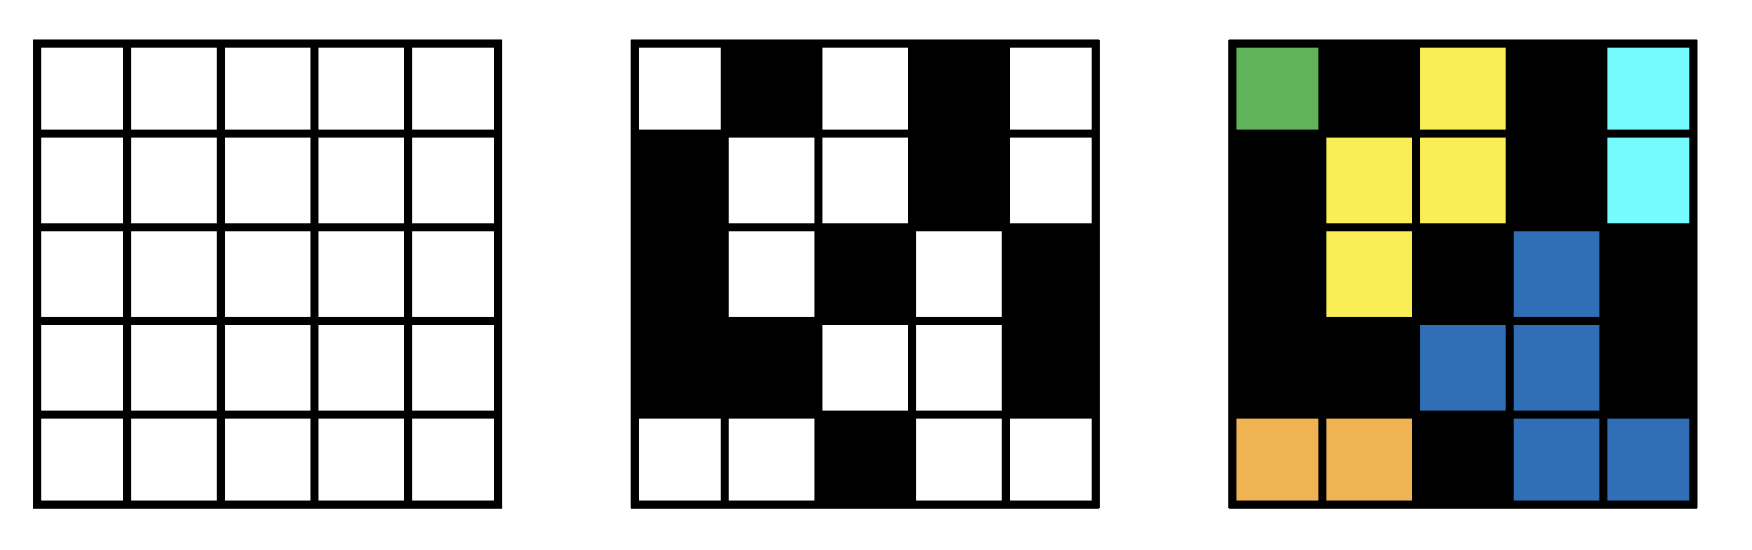

At small $p$, we should expect many unconnected clusters (left, below); at large $p$, we may expect one large cluster to span the space (right, below).

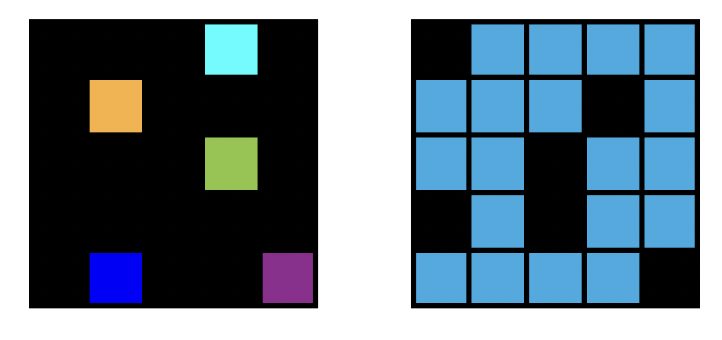

A system is said to _percolate_ if there exists at least one cluster which spans the space, meaning the cluster reaches from one side of the $N \times N$ grid to the other. We often explore a grid with periodic boundary conditions (i.e. we wrap the grid up into a torus by stitching opposite edges together); in this case, the system is said to percolate if there is a cluster which "wraps around" the grid. In the image below, the left cluster spans and wraps the grid; the center cluster spans the grid but does not wrap around it; the right cluster neither spans, nor wraps the grid.

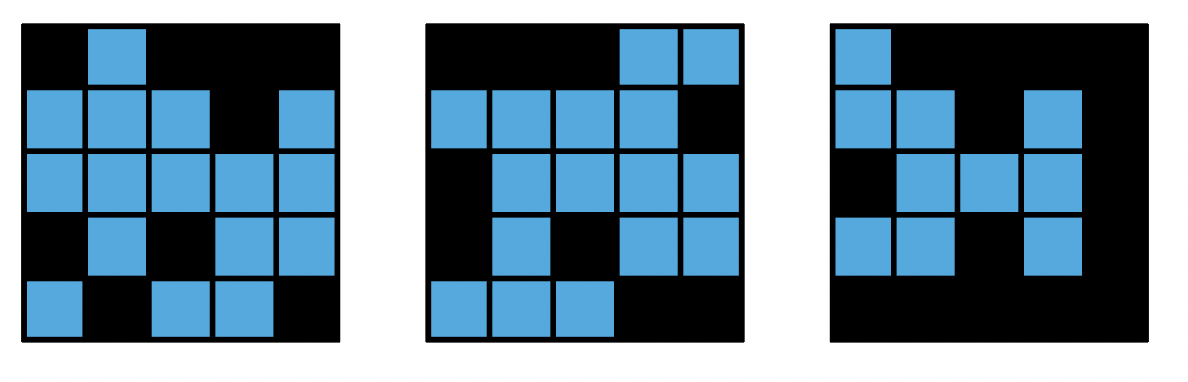



The surprising property of percolation is, as $N \rightarrow \infty$ there exists a critical probability $p_c$ above which there _always_ exists a percolating cluster, and below which there _never_ exists a percolating cluster; i.e. we have a phase transition! [1][9]. 

To get a feel for this behaviour, below is a short demonstration which finds and labels clusters, and display the grid (of course, it's not very efficient!). It can be fun to play around with, varing the parameters $N, p$. Some simple exploration confirms that a phase transition does exist, somewhere in the region of $p=0.59$, which we will make more precise later.

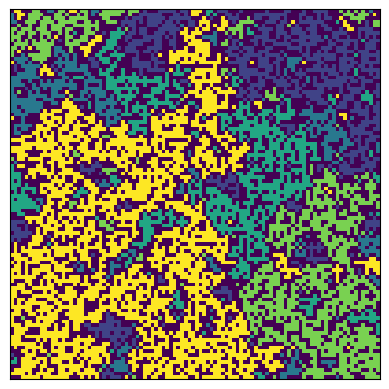

In [10]:
import demos

grid = demos.Grid(N=100, p=0.59)
grid.get_clusters()
grid.display()

The above description is, in fact, a special case of a more general class of percolation problems. The system described is called _site percolation_ on a _square lattice_. We can also have bond percolation (on a graph, where the edges can be open or closed), or percolation on a triangular/hexagonal lattice, or a 3D lattice, etc. However, in this report we focus on site percolation on the $N \times N$ square. This allows us to explore all the key behaviours of percolation in detail, and is also the most extensively studied in the literature.

The rest of the report will proceed as follows:
- **Section 1:** Analysis of Algorithms. We will introduce 3 algorithms to study percolation, explain their uses/advantages, and discuss their complexity (without writing any code).
- **Section 2:** Implementation of Algorithms. We will explain the code used to implement the 3 algorithms, and provide some demonstrations. We will then do some basic analysis of the performance of the 3 algorithms, comparing to the theoretical complexity.
- **Section 3:** Tests & Results. We will use the algorithms to explore percolation and its phase transition, comparing our results with theory.

## Section 1: Analysis of the Computational Physics
Before discussing specific algorithms, let's talk about the general computational complecity of the problem. On an $N \times N$ grid, we must check at least $N^2$ bonds to identify the clusters; thus, identification of clusters is (at best) an $O(N^2)$ operation on a single grid. To then explore _all possible_ grids of size $N \times N$ (which would be required exact results on this grid), we would have to look at $2^{N^2}$ grids, and so labelling all clusters in all configurations would scale as $O(2^{N^2} \cdot N^2)$. This is awful, and makes exact results impossible past (roughly) $N=6$, for which we would have to perform $2^{41}$ operations. 

Therefore, we seek algorithms that "discard" almost all the states (and/or cluster labelling), while still retaining appropriately sampled states and measurements such that we can extract accurate and precise values for the quantities we wish to explore. We present 2 algorithms which appropriately sample random states, and one algorithm which is exact.

### Single Cluster Growth: the Leath-Alexandrowicz method 
This algorithm was proposed in [1] and [2]. The main idea is that, instead of labelling an entire grid, we can simply "grow" clusters from a single origin point, at given $p$. By exploring the average properties of these clusters over $p$, we can learn about the percolation transition.

First, how do we grow the clusters? The basic idea is this:
- Start off with a single site in open configiration.
- Go round the neighbouring sites, choose whether the site is open or closed with probability $p$. For open sites, add them to a 'queue' of _unchecked sites_. For closed sites, add them to a list of _visited sites_.
- "Pop" a site from the _unchecked sites list_, and check its neighbouring sites in the same way.
- Repeat this process this until the unchecked sites list is empty, at which point we have grown a full cluster (with an entirely "closed" perimeter) 

This process is illustrated below. We start off with a single open site (yellow). Its neighbours are then chosen to be open (blue,  appended to the unchecked queue) or closed (black). We then pop the first site from this queue (1), and check its neighbours (orange); the open ones are added to the queue. This process is repeated until the unchecked site queue is empty, and a full cluster has been grown. This is called a First-In-First-Out (FIFO) method, as the unchecked list is emptied "from the bottom".

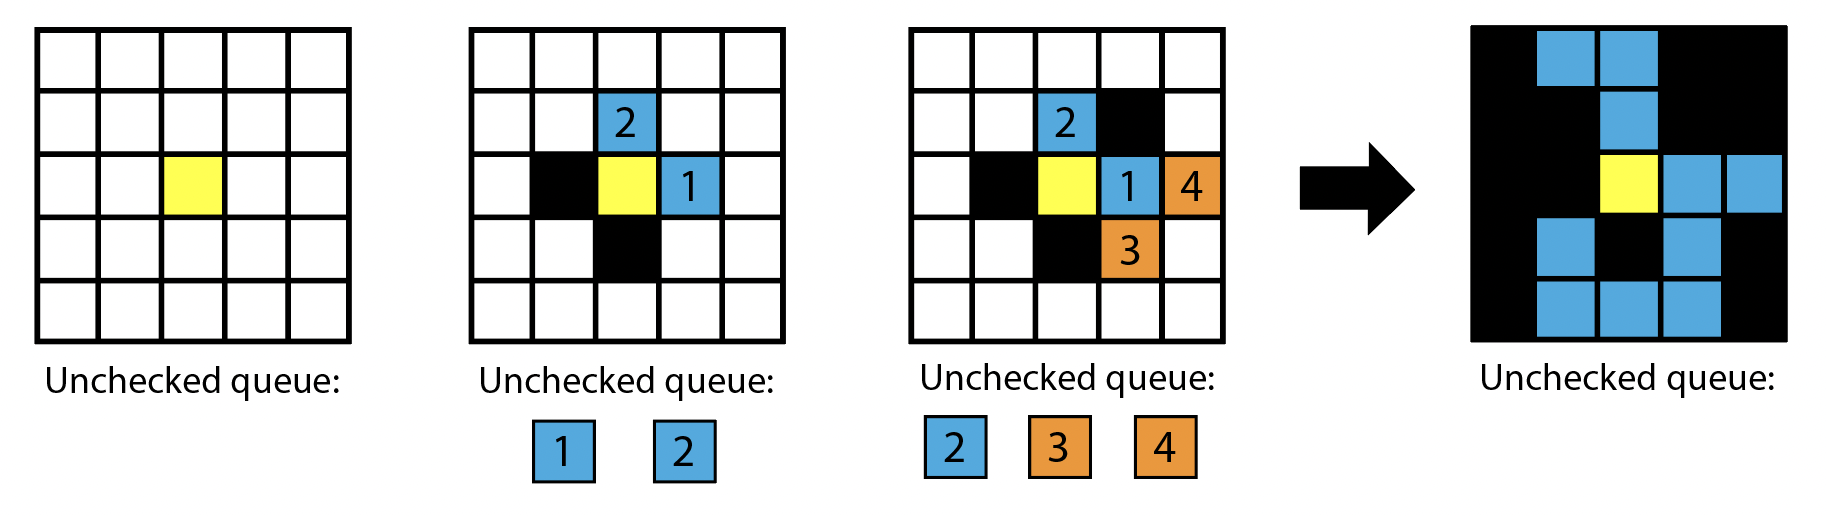

A demonstration below carries out this algorithm and displays the resulting cluster. We will review the implementation in Section (2a), but playing around with this at different $p$ helps us gain an understanding of the typical clusters we might create.

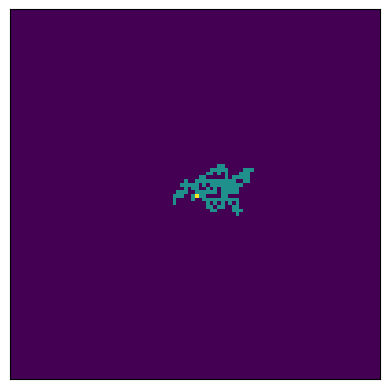

In [11]:
import demos

FIFO_demo = demos.GridIllustration(100, 0.5)
FIFO_demo.grow_from_seed_FIFO((50, 50))
FIFO_demo.display()

Let's now analyse the complexity of the the Leath-Alexandrowicz method, and its uses in investigating percolation. 

**Complexity**\
Each site in a growing cluster requires the following for each neighbour: check its status, and add it to an appropriate list. Both of these processes are $O(1)$, and so the number of steps in "growing" the cluster scales as $O(n)$ where $n$ is the number of open sites in the cluster.

A well known result from percolation theory [8] states:
> For any given site of any given finite cluster at probability $p$, the average size $S(p)$ of the cluster is scales as $S(p) \propto  |p-p_c|^{-\gamma}$.

Thus, the expected number of operations we must perform at a given probability $p$ as $O(|p-p_c|^{-\gamma})$. Of course, we will set an upper limit on cluster size to prevent the growth of infinite clusters; thus, the expected complexity at given $p$ should scale as $O(\text{max}(|p-p_c|^{-\gamma}, n_\text{max}))$, where we expect to transition to constant behaviour just below $p_c$. Note that $p_c, \gamma$ have approximate values $0.5927, 2.389$ respectively [3].

Of course, making measurements on our grown cluster may increase the compexity.

**What is it good for?**\
We can investigate the following "physical" properties of clusters using this method:
- Typical cluster size (mean, distribution...) at given $p$.
- Critical probability and scaling exponents $p_c, \gamma$...

By investigating these properties, we may make accurate estimations of physically interesting constants relating to percolation. The algorithm also has the advantage that (unlike the algorithms which we will introduce below) we do not need to perform a "full sweep'; i.e. we can make as many/few measurements as we want, at any chosen set of $p$ values. We will make measurements of thse values in Section 3.


### Monte Carlo Percolation: the Newman-Ziff method
A Monte Carlo method was introduced [3] to accurately measure percolation quantities without having to go through all possible configurations. This algorithm has become central to computational percolation, aided by the clarity of the original paper in which it was introduced.

The central idea is this: for a an observable $Q$, which has expected value $\overline{Q_n}$ for a lattice of $n$ occupied sites (out of $M$ lattice sites), the expectation value $Q(p)$ at given p can be calculated:
$$ Q(p) = \sum_{n=0}^M {M \choose n} p^n (1-p)^{M-n} \overline{Q_n} $$
Newman and Ziff call $Q_n$ the _microcanonical_ ensemble value, and $Q(p)$ the _canonical_ ensemble value ($n$ and $p$ take the analagous roles to energy and temperature in thermodynamics). Thus, calculation of $Q(p)$ requires only calculation of an accurate set $\{ \overline{Q_n} \}$

The Newman-Ziff algorithm performs a full, representative sweep measuring $\{ Q_n \}$ in a time scaling as $O(M) = O(N^2)$ (for system size $M$). This is substantially better than the $O(M^2) = O(N^4)$ complexity which a naïve implementation would require to perform such a sweep (with $N^2+1$ values of $n$, each requiring time $O(N^2)$ time to label). The disadvantage of the algorithm is that we _have_ to perform a full sweep (or at least sweep _up to_ a given $n$); we cannot measure $Q_n$ at a few chosen values of $n$. 

The Newman-Ziff algorithm requires essentially 3 steps:
1. Generate a random order in which to occupy sites on the lattice. This is an $O(M)$ operation.
2. Add sites in the order decided. For each added site, we must **find** the cluster to which all of its (open) neighbours are attached, and (if these are different), **union** the clusters. Using a tree-based find-union data structure (discussed below), each added bond takes $O(1)$ time (see a detailed discussion in [3]), and so this whole process takes $O(M)$ time.
3. After each site is added, measure $Q_n$, which takes (at best) $O(1)$ time.

Thus, performing a whole, representative sweep over all $Q_n$ takes $O(M)$ time. By carrying out this process multiple times and taking an average, we can generate a precise set $\{\overline{Q_n} \}$, from which we can calculate $Q(p)$ using the formula above.

Let's now go through the steps in detail.

**Site permutation**\
We can generate a random permutation of the $M$ sites, from an ordered list, as follows:
1. Set $i=1$
2. Choose a random number $j \in [i,M]$
3. Swap elements at sites $i,j$
4. Set $i \leftarrow i+1$
5. Repeat until $i=M$
This evidently produces a random configuration in $O(M)$ time, as desired. An instance of this algorithm has been shown below for $M=9$. The first $j$ was randomly chosen as $4$, then $9$, and so on, until the set is randomly permutated.

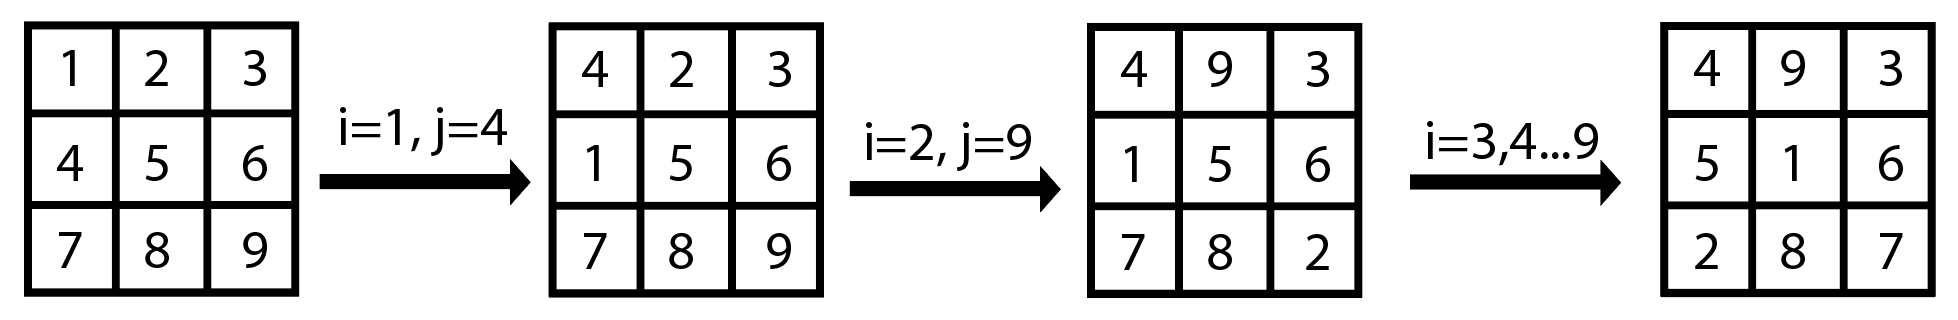

**Union/Find (Tree Based)**\
The data structure corresponding to the grid is a of a list of _pointers_, of length $M$. The pointers have integer values: $0$ for an unoccipied site, $-n$ for the "root site" of a cluster of size $n$, and $i$ for a non-root element in a cluster, where $i$ points to another element in the cluster. Then:
- **Find**: to find the root of a starting from a pointer with label $i$, follow the (non-negative) pointers (i.e. from pointer $i$, jump to pointer which has position $i$ in the list, with label $j$, and repeat) until a negative pointer is found. Then, go back along the path, changing all pointers so they point to the root element.\
This process is illustrated below; the small black number refers to the index, and the big number is the pointer value. Following the path from the top site leads us to the root node; we then go back along the path, updating the pointers.
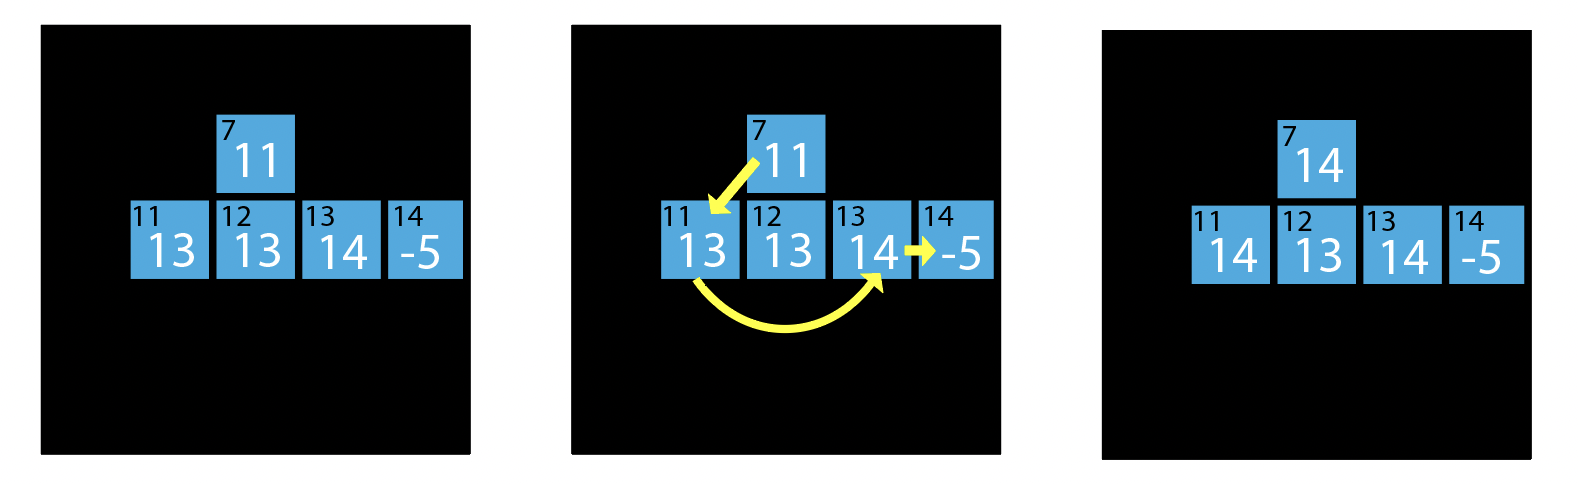
- **Union**: Follow pointers from each site separately until we reach the root sites of the clusters to which they belong. Then go back along the paths, through each tree and adjust all pointers along those paths to point directly to the corresponding root sites. If the two root nodes are different, we examine the cluster sizes stored in them, and add a pointer from the root of the smaller cluster to the root of the larger, thereby making the smaller tree a subtree of the larger one. Update the size of the larger cluster by adding the size of the smaller one to it. This process is illustrated below.
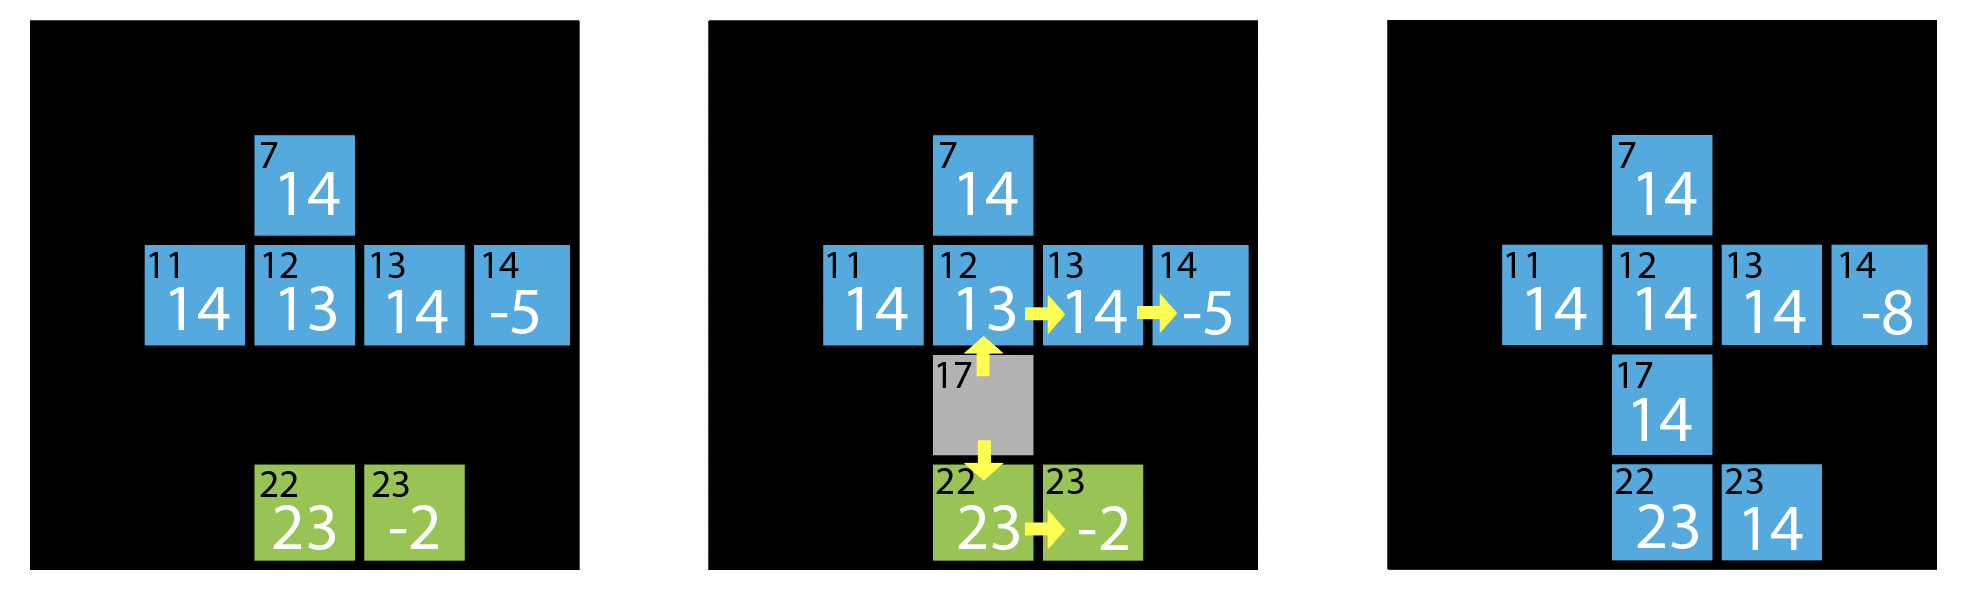

We can therefore update the lattice by adding open sites in the random order decided above; if an added site has one neighbour, label the site by performing _find_ on its neighbour. If an added site has 2 (or more) nieghbours, label the site while performing _union_ on the neighbours. 

By labelling the root sites according to size (_weighting_), and performing this relabelling procedure along the paths (_path compression_), it can be shown that the time taken by both the union/find steps is $O(1)$ in the system size, and thus adding all $M$ bonds is $O(M)$ (for a detailed discussion of this, see [3]).

**Measuring Q**\
We can now review some examples of the types of observabled $Q$ which we might wish to measure.
- **Max cluster size**: $Q_n$ is simply the magnitude of the most negative number in the list of pointers.
- **Average cluster size**: can be calculated as the number of non-0 values in the pointer list, diivided by the number of negative values.
- **Cluster spanning**: We start off with all sites along the left/right edges "open". To check if there is a spanning cluster, simply check if elements on the left and right have the same root, using the _find_ operation.
- **Cluster wrapping**: In a (finite) system with periodic boundary conditions, wrapping measurements often provides faster converging estimates than spanning measurements [4]. When performing a _union_ between 2 sites which belong to the _same cluster_ (i.e. same root), check the relative displacements between each of the sites and their root site. This should equal one lattice spacing; if it is not, then wrapping has occured. We can terminate the sweep here, if we only wanted to detect the onset of wrapping. This is discussed in more detail in Section 3.

The above measurements of spanning and wrapping require, at most, 2 find operations, and thus can be taken in $O(1)$ time. Measurements of average cluster size may take longer.



We have now seen how the Newman-Ziff method can accurately sample the space of lattices in order to calculate $Q(p)$ for a general observable $Q$. However, this requires multiple runs, and is inexact.

### Exact Probabilities: the Mertens Algorithm

We have introduced two algorithms (Leath-Alexandrowicz, and Newman-Ziff) which can _estimate_ quantities relating to site percolation on the square lattice. However, we may seek a method which generates _exact_ results, for an $N \times N$ lattice. The Mertens algorithm [5] is such a method. In the Mertens algorithm, we enumerate _all possible configurations_ from the top down; a number of clever tricks are then used to appropriately "throw away" data, while keeping our results exact. The consequence is that we can generate arbitrarily precise values of quantities like $p_c$; but the cost is that this algorithm does not scale well as we increase $N$. By splitting the larger problem into smaller iterative steps, this algorithm makes use of the _dynamic programming_ paradigm.

At the center of the Mertens algorithm is a _generating function_ $F_{N,N}(z)$, defined:
$$ F_{N,N}(z) = \sum_{k=0}^{N^2} A_{N,N}(k) z^k $$
where $z \in [0,1]$ is the input to the function, and $A_{N,N}(k)$ is the number of _percolating_ (spanning, as we do not use periodic BCs here) configurations with $k$ open sites on an $N \times N$ grid. Simmilar to a partition function in statistical physics, desirable quantities can be read off exactly from $F$; for example, the spanning probability $R$ at occupancy $p$ is given by [5]:
$$ R_{N,N}(p) = (1-p)^{N^2} F_{N, N} \bigg( \frac{p}{1-p} \bigg)  $$
The Mertens Algorithm is a method to calculate $F(z)$. The basic idea is this: we assign an $F$ each possible configuration $\sigma$ of a row, denoted $F_{nm}^\sigma(z)$ (for grid width $n$, row depth $m$). We can then use a _transfer matrix_ to generate the $F_{n, m+1}$ for the next row down. For example, in the case $n=2$, we can write down the transfer matrix as shown (see [5]):
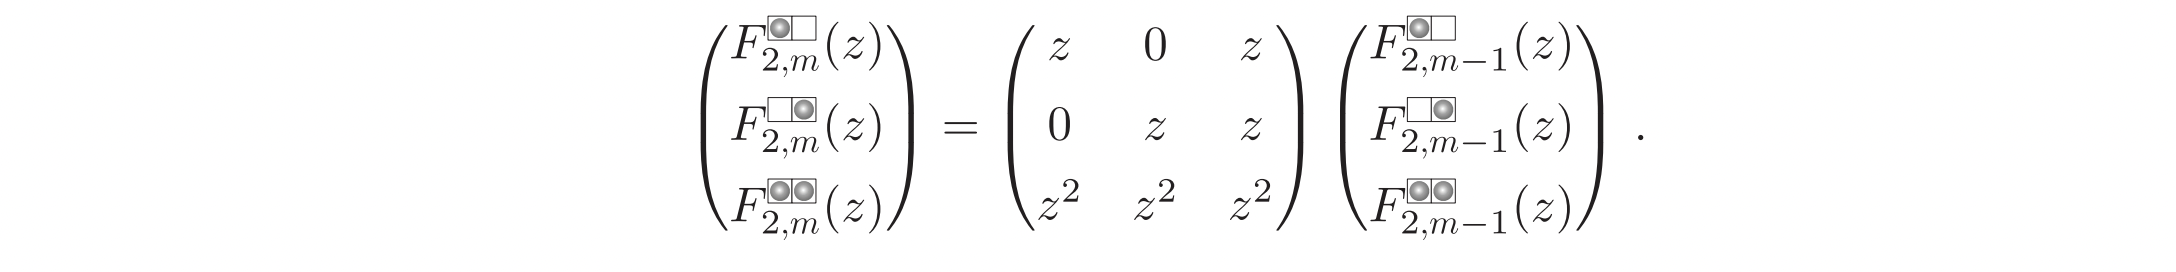
This idea can then be extended from adding rows to adding individial sites. A set of $N$ sites corresponding to the lowermost row (with a kink at column $c$; shown in red box below) is stored as a _signature_ $\sigma$, with associated $F^\sigma$. From this signature, the 2 possible signatures $\sigma_0$, $\sigma_1$ corresponding to adding a closed/open site at column $c+1$ are generated (along with their associated $F$), as shown:
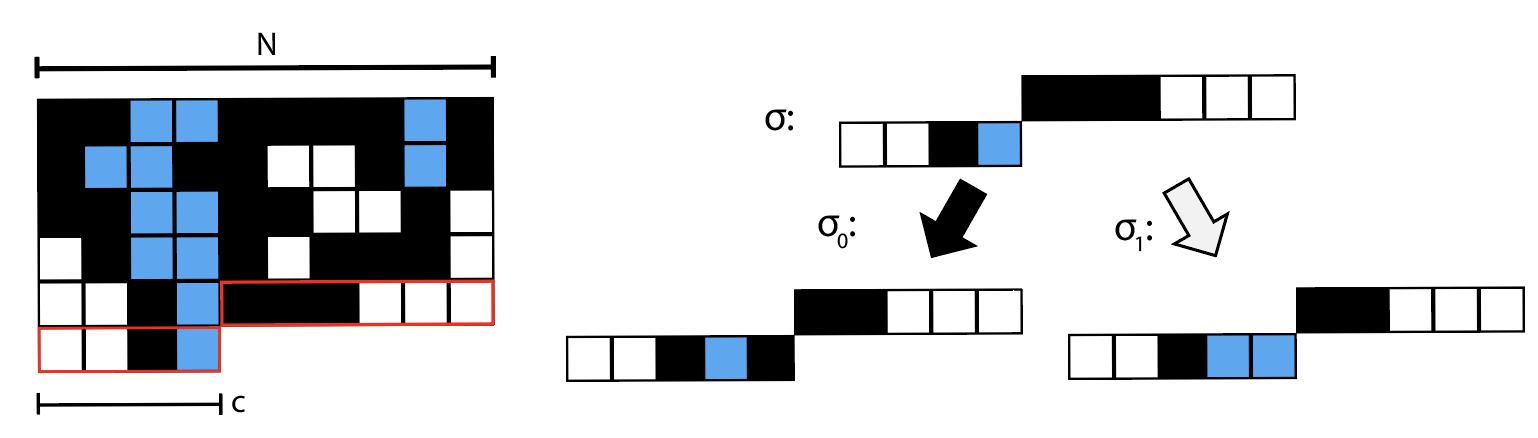
For the sites in the signature, it is sufficient to store only what "type" of site it is, which may fall into 6 catagories: closed, an element connected to the top (shown in blue, above), a leftmost element of a cluster in the signature, a rightmost element, an isolated element, or a middle element. Thus each element in a signature (of length $N$) is denoted by one of 6 symbols. The signatures are updated according to _extension rules_, shown in Table 3 of [5]. These rules are numerous and uninteresting, so we will not discuss them here (although we will, of course, implement them in Section 2). 

By iteratively generating all possible signatures $\sigma$ as we progress through each site in the grid, and discarding/merging appropriate signatures, we can calculate $F(z)$ exactly, without having to enumerate $2^{N^2}$ configurations!

**Complexity & Performance**\
As the algorithm is exact, it cannot be expected to be very fast. In fact, a lengthly discussion in [5] (which we will not reproduce here) concludes that the time complexity of the algorithm scales as $O(2.6^N)$ for a lattice of side length $N$. Although this is exponential scaling, it is significantly better than the $O(2^{N^2})$ complexity which we would expect from enumerating all possible configurations; calculations up to approximately $N=10$ are therefore feasible in a short amount of time.

Unlike the other algorithms, the Mertens algorithm requires the storage of a huge number of configurations, and so the scaling of storage required becomes a significant problem. It can be shown that the amount of information stored also scales as $O(2.6^N)$; therefore, computations are possible up to $N=18$ using 16-bit integers on a laptop with around 8GB of RAM (although it takes a while, and so getting any useful data out of an $N=18$ grid is impractical).

We will verify this time complexity in Section 2 of the report, along with its implementation.

**What can we measure with the Mertens Algorithm?**\
The Mertens algorithm allows us to calculate $F(z)$, and in turn $R_{N,N}(p)$, as discussed above. We can then calculate percolation thresholds $p_\text{cell}, p_\text{med}$ defined as:
$$ R_{N,N}(p_\text{cell}) = \frac{1}{2} $$
$$ R_{N,N}(p_\text{med}) = R_{N-1, N-1}(p_\text{med}) $$
For system size of $N \times N$, both these values are expected to scale as (compared to the $N \rightarrow \infty$ limit, which is $p_c$ for both) [6]:
$$ |p_\text{med}-p_c| \propto |p_\text{med}-p_c| \propto N^{-7/4}  $$
It can also be shown that the "estimator" $p_* := \frac{4}{7} p_\text{med} + \frac{3}{7} p_\text{cell}$ converges much faster than either of the individual values.

Thus, the Martens algorithm allows us to calculate the percolation threshold $p_c$ very precisely through the use of finite estimators. However, that's basically it! We can't calculate things like the cluster size distribution, as we could using the other two algorithms.



## Section 2: Implementation
After a healthy discussion of theory, we now move onto the implementation of the above algorithms, in the order in which they were introduced. 

<ins> Hardware:</ins> All the below tests of performance and runtime results are from runs on an M2 2022 Macbook Air, with 8GB RAM. Tests were run in a Jupyter Python 3.11 Virtual Environment, in VS Code. 




### Leath-Alexandrowicz Implementation
Implementing the FIFO Leath-Alexandrowicz method is fairly simple. We start off from an initital site on a grid, and go around the neighbours, assigning them as open or closed, as described in Section 1.

The main difficulty is this; we either need to start with an existing grid of labels (which constrains the maximum size of the cluster), or we need to increase the size of the grid as we grow. The implementation below uses the former; this is for two reasons:
- It is generally slow to constantly append elements to large lists (numpy arrays), as this requires making a copy of the list in the memory. Therefore, growing the list of labels as the cluster grows would be slow.
- We must already constrain the size of the cluster to prevent the growth of an infinate cluster, and so a natural constraint on size in the code is not too problematic.

We therefore initialize the labels in a 2D numpy array called _identities_ with all $0$'s, corresponding to unassigned. We then assign $1$ for an open site, and $-1$ for a closed site. We choose to initialise the array with zeros, instead of using the (faster) np.empty array, as this means the array also keeps track of which sites we have been _visited_.

The implementation below initializes a grid into the class _Grid_. The method _grow\_from\_seed\_FIFO_ then grows clusters from the center point of the grid, as described above. 2 other methods are included; _get\_neighbours_ returns the neighbours of a point, and _display_ creates a visualization of the Grid in a window near the middle.

In [12]:
class SingleClusterGrid():
    """
    A class containing a lattice on which clusters can be grown, and method(s) to grow clusters.
    ...

    Attributes
    ----------
    demensions : tuple of 2 ints
        dimensions of lattice; should be an NxN grid
    identities : (N,N) numpy array of dtype 'i1'
        an array corresponding to the identitites of each site. 0 for unassigned, 1 for open, -1 for closed. 
    size : int
        size of a grown cluster (if saved)
    perimeter : int
        perimeter length of a grown cluster (if saved)

    Methods
    -------
    get_neighbours(coord)
        Returns (up to) 4 neighbours around coord. Discards neighbours which fall outside of the grid (no periodic BCs).
    grow_from_seed_FIFO(p: float, max_size:int, save:bool)
        Grows a cluster from the center point of the grid
    display(window_size: int)
        Displays the cluster in a window around the center
    """

    def __init__(self, N: int) -> None:
        """
        Initializes the grid.

        Parameters
        ----------
        N : int
            The grid size NxN
        """
        self.dimensions = (N,N)
        self.identities = np.zeros(self.dimensions, dtype='i1')
    
    def get_neighbours(self, coord: tuple) -> list:
        """
        Returns (up to) 4 neighbours around coord. Discards neighbours which fall outside of the grid (no periodic BCs).

        Parameters
        ----------
        coord : tuple
            The coordinates from which we will generate neighbours
        
        Returns
        ----------
        neighbours : list
            A list of neighbour coordinates
        """
        row, col = tuple(coord)
        neighbours = [(row, col+1), (row-1, col), (row, col-1), (row+1, col)] #create neighbours list in desired order
        neighbours = [coord for coord in neighbours if (coord[0] >=0 and coord[1]>=0 and coord[0]<self.dimensions[0] and coord[1]<self.dimensions[1])] #discard appropriate neighbours
        
        return neighbours

    def grow_from_seed_FIFO(self, p: float, max_size = 10**5, save=False):
        """
        Grows a cluster from the center point of the grid

        Parameters
        ----------
        p : float
            Occupation probability p
        max_size: int, optional
            Maximum cluster cutoff (default = 100,000)
        save: bool, optional
            Whether to save the cluster labels, size, perimeter (useful for displaying)
        
        Returns
        ----------
        identities : (N,N) numpy array of dtype 'i1'
            An array corresponding to the identitites of each site. 0 for unassigned, 1 for open, -1 for closed. 
        size : int
            Size of grown cluster
        perimeter : int
            Perimeter length of grown cluster
        """
        center_point = self.dimensions[0]//2
        seed_coords = (center_point, center_point)

        identities = self.identities #create a copy, in case we don't want to save
        identities[seed_coords] = 1
        size = 1
        perimeter = 0

        queue = [seed_coords]
        while queue != [] and size<=max_size:
            site = queue.pop(0) #First in, First out!
            for neighbour in self.get_neighbours(site):
                if identities[neighbour] == 0:
                    if np.random.rand() <= p: #decide occupation
                        identities[neighbour] = 1
                        queue.append(neighbour)
                        size += 1
                    else:
                        identities[neighbour] = -1
                        perimeter += 1

        if save:
            self.identities = identities
            self.size = size
            self.perimeter = perimeter

        return identities, size, perimeter

    def display(self, window_size = 100) -> None:
        """
        Display the grid

        Parameters
        ----------
        window_size : int, optional
            Display the grid around the center in a square of width & height window_size (defauly = 100) 
        """
        fig, ax = plt.subplots()
        win_max = (self.dimensions[0]+window_size)//2
        win_min = (self.dimensions[0]-window_size)//2
        plt.imshow(self.identities[win_min:win_max, win_min:win_max]) #display only in window
        ax.set_xticks([]) #ensure no ticks on side
        ax.set_yticks([])


Let's check that the clusters we have grown look good:

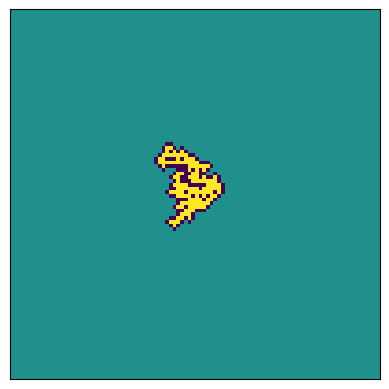

In [13]:
test_grid = SingleClusterGrid(1000)
test_grid.grow_from_seed_FIFO(0.55, save=True)
test_grid.display()

Now that we have verified our code is functioning properly, we can compare the complexity with the theoretical value. As a reminder, we expect the code to run in $O(S)$ time with cluser size $S$. As we sweep through different values of $p$, the complexity should therefore scale as  $O(\text{max}(|p-p_c|^{-\gamma}, S_\text{max}))$.

Let's first verify this $O(S)$ behaviour in cluster size. We choose an appropriate $p = 0.55$ to ensure a good range of sizes are generated.

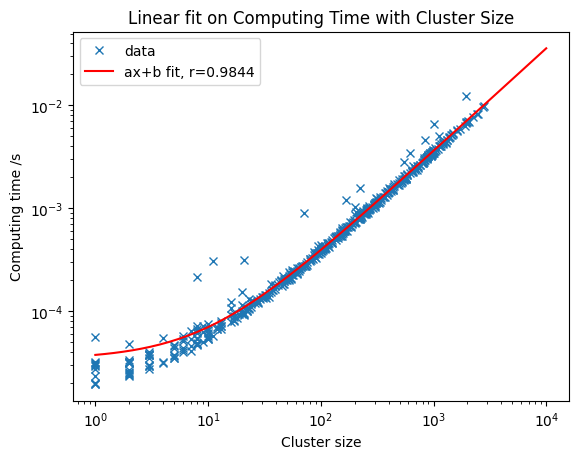

In [14]:
times = []
sizes = []

for random_grid in range(500):
    timing_grid = SingleClusterGrid(10**5) #initialize a new grid

    t_0 = time.perf_counter()
    identities, size, perimeter = timing_grid.grow_from_seed_FIFO(0.55, max_size=10**7) #perform growth from seed
    t_1 = time.perf_counter()

    times.append(t_1-t_0)
    sizes.append(size)

plt.loglog(sizes, times, 'x', label = 'data')
plt.xlabel('Cluster size')
plt.ylabel('Computing time /s')

slope, intercept, r, p, std_err = stats.linregress(sizes, times)
x_space = np.logspace(0, 4)
plt.loglog(x_space, intercept + slope * x_space, color="red", lw=1.5, label = 'ax+b fit, r='+str(round(r, 4)))

plt.title('Linear fit on Computing Time with Cluster Size')
plt.legend()
plt.show()

As we expected, there is a very good linear fit between computing time and cluster size, and so the hypothesized $O(S)$ behaviour is observed. Note the non-0 intercept; this is likely due to the $O(1)$ time required to initialise the whole grid to unassigned.

For good measure, let's check the expected behaviour over a range of $p$:

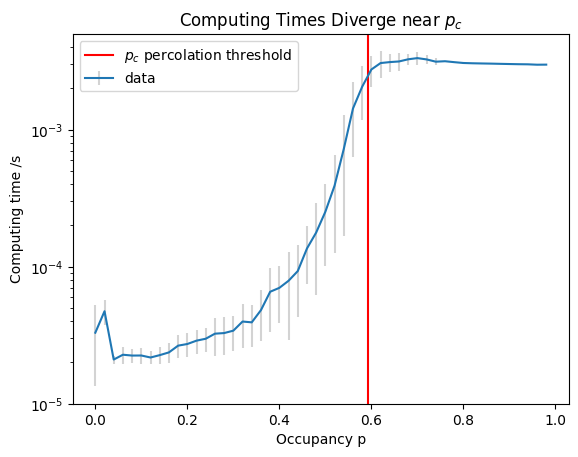

In [15]:
ps = np.arange(0.0, 1.0, 0.02)

times = []
times_std = []

for p in ps:
    run_times = []
    for run in range(100):
        timing_grid = SingleClusterGrid(10**5) #initialize a new grid
        t_0 = time.perf_counter()
        identities, size, perimeter = timing_grid.grow_from_seed_FIFO(p, max_size=10**3) #perform growth from seed
        t_1 = time.perf_counter()
        run_times.append(t_1-t_0)
    times.append(np.mean(run_times))
    times_std.append(np.std(run_times))

fig, ax = plt.subplots(1,1)

ax.set_yscale("log", nonpositive='clip')
ax.errorbar(ps, times, yerr= [0.6*sigma for sigma in times_std], ecolor='lightgrey', label='data')
ax.set_ylim(bottom=10**(-5))

ax.axvline(0.5927, color = 'red', label = '$p_c$ percolation threshold')

ax.set(title='Computing Times Diverge near $p_c$')
ax.set(ylabel='Computing time /s')
ax.set(xlabel='Occupancy p')
ax.legend(loc='upper left')


plt.show()

This looks as expected:
- At low $p$, the computing time is roughly constant, set by the initialization time of the lattic.
- As we approach $p \rightarrow p_c$, the computing time diverges, as the expected cluster size (and so expected time) diverges.
- At $p>p_c$, we see a roughly constant time; this is as almost all the clusters reach the maximum allowed size.

Measurement of $p_c, \gamma$ from this graph will be discussed in Section 3 (Results).

### Newman-Ziff Implementation
We now move onto the implementation of the Newman-Ziff algorithm. As discussed, this algorithm proceeds in 3 stages:
1. Initialization: create a square grid, and permute the filling order
2. Addition of open sites, using the tree-based Find-Union algorithm
3. Measurement of quantitities $Q_n$

where the last 2 stages are repeated $M$ times.

As before, we write the grid as a Class, called _ZiffGrid_. The class is then initialized with a random permutation for the filling order, using the algorithm described above. The class is endowed with 3 methods. _findroot_ finds the root node (with a negative pointer), from a given site. _measure\_Q_ takes a measurement of $Q_n$ (we will leave this blank for now). Finally, _percolate_ performs a full sweep of $Q_n$. 

Note that the code used here is in many cases almost identical to the C code provided in [3], making only small changes to make the code more "pythonic".

In [16]:
class ZiffGrid():
    """
    A class for implementing the Newman-Ziff algorithm.
    ...

    Attributes
    ----------
    L,N : int
        dimensions of lattice; N=LxL
    ptr : numpy array of dtype int, size (N)
        numpy array containing the pointers. Pointers have value i for an open site (pointing to another site at position i), 
        -n for a root of a cluster of size n, or -N+1 for a closed site.
    order : numpy array of dtype int, size (N)
        Order (occupation number) in which to fill the lattice
    nn : numpy array of dtype int, size (N, 4)
        a list of the nearest neighbours of each site on the lattice

    Methods
    -------
    findroot(coord: int) -> int
        Find the root site of a cluster from element of index coord, and shorten the path.
    measure_Q() -> float
        Measure some observable quantitity Q_n of the lattice
    percolate()
        Percolate in the order given, joining clusters appropriately
    """
    def __init__(self, L: int) -> None:
        """
        Initialize the lattice, with assigned nearest neighbours and a random filling order.

        Parameters
        ----------
        L : int
            The lattice side length
        """
        self.L=L
        self.N=L**2
        

        self.pointers=np.zeros(self.N, dtype=int)                  # array of pointers
        self.neighbours=np.zeros((self.N, 4), dtype=int)           # nearest neighbors
        self.order=np.zeros(self.N, dtype=int)                     # occupation number

        #Generate the random orders of site occupation, by switching random elements
        order = np.arange(self.N, dtype=int)
        for i in np.arange(self.N, dtype=int):
            j = int(i + (self.N-i)*random.random())
            temp = order[i]
            order[i] = order[j]
            order[j] = temp
        self.order = order

        #Set the boundaries, with periodic BCs
        for i in range(self.N):
            self.neighbours[i, 0]=(i+1)%self.N
            self.neighbours[i, 1]=(i+self.N-1)%self.N
            self.neighbours[i, 2]=(i+L)%self.N
            self.neighbours[i, 3]=(i+self.N-L)%self.N

            if i%L==0: self.neighbours[i, 1]=i+L-1 #impose periodic BCs
            if (i+1)%L==0: self.neighbours[i, 0]=i-L+1
    
    def findroot(self, i: int) -> int:
        """
        Find the root node from a position, and compress the path taken to that point. 
        Almost identical to the (very efficient) C code used in the original paper.

        Parameters
        ----------
        i : int
            The position of the element from which we wish to find the root of the cluster

        Returns
        ----------
        pointers[i] : int
            The position of the root node of the cluster
        """
    
        if (self.pointers[i]<0): #if root node
            return i
        else: 
            self.pointers[i] = self.findroot(self.pointers[i]) #proceed along the path, performing compression
            return self.pointers[i]

    def measure_Q(self) -> None:
        """
        Measure some observable Q_n. Fow now, we leave this blank.
        """
        pass
    
    def percolate(self):
        """
        Perform the percolation sweep. Again, the code here is nearly identical to the original paper.

        Returns
        ----------
        ns : list of length N
            The occupation numbers n of each step along the sweep
        Qs : list of length N
            The values Q_n at each probability n in ns
        """
        empty=-(self.N+1) #unassigned grid value

        ns=np.zeros(self.N)
        Qs=[]

        for i in np.arange(self.N): #initialize the grid to empty
            self.pointers[i]=empty

        for i in np.arange(self.N):
            site_pos=site_pos_copy=np.copy(self.order[i]) #site position to occupy
            self.pointers[site_pos_copy]=-1 #set site as the root of its own cluster
            
            
            for neighbour_pos in self.neighbours[site_pos_copy]: #checking the neighbours
                if self.pointers[neighbour_pos] != empty: #if in grid
                    neighbour_root=self.findroot(neighbour_pos) 
                    if (neighbour_root!=site_pos): #if neighbour belongs to cluster
                        if self.pointers[site_pos]>self.pointers[neighbour_root]: #if site does not already belong to cluster, merge in
                            self.pointers[neighbour_root]=self.pointers[neighbour_root]+self.pointers[site_pos]
                            self.pointers[site_pos]=neighbour_root
                            site_pos=np.copy(neighbour_root)
                        else: #adjust the path
                            self.pointers[site_pos]=self.pointers[site_pos]+self.pointers[neighbour_root]
                            self.pointers[neighbour_root]=site_pos
                
                #record n, Q_n
                ns[i]= (i+1)
            Qs.append(self.measure_Q())
            
        return ns, Qs



First, let's verify that our code actually works. Since it is an easy measurement to perform, we make a new class (inherited from ZiffGrid) where Q measures the largest cluster size (in a fairly inefficient way; this will be improved in Section 3). We then check that it appropriately generates average clsuter sizes over the single sweep on a $40\times 40$ grid:

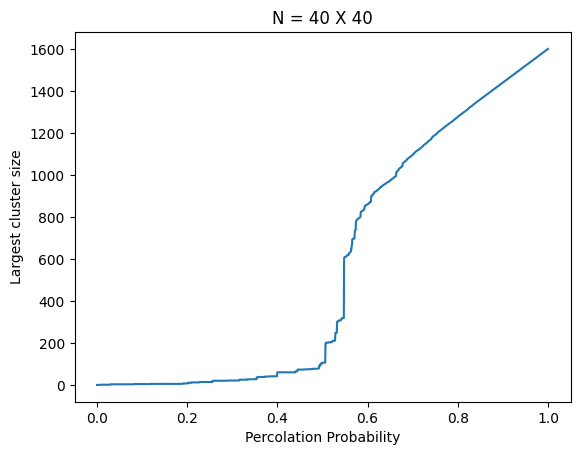

In [17]:
class ZiffGrid_ClusterSizeMeasurement(ZiffGrid):
    def measure_Q(self) -> float:
        largest = -1
        for pointer in self.pointers:
            if pointer<largest and pointer!= -(self.N)-1:
                largest = pointer
        return -largest

L=40
test_Ziff = ZiffGrid_ClusterSizeMeasurement(L)
ns, Qs = test_Ziff.percolate()

plt.plot([n/L**2 for n in ns], Qs)
plt.xlabel("Percolation Probability")
plt.ylabel("Largest cluster size")
plt.title("N = " + str(L) + " X " + str(L))
plt.show()

This looks like the kind of behaviour we might expect, with 3 distinct regions:
- $p<0.4$: no large clusters forming
- $p \in [0.4, 0.6]$: as we approach the critical point, clusters grow larger and merge together
- $p>0.6$: a single percolating cluster dominates; this increases in size as (internal) closed sites become open

Our code seems to be functioning appropriately. We now wish to verify the scaling complexity. As a reminder, we expect the sweep to take time $O(L^2)$ for side length $L$ of the grid. Let's verify this behaviour:

In [18]:
times_avg = []
times_std = []
Ls = np.arange(5, 100, 1)
Ms = [L**2 for L in Ls]

for L in Ls:
    times = []
    for i in range(10):
        t_0 = time.perf_counter()
        timing_grid = ZiffGrid(L) #initialize a new grid
        timing_grid.percolate() #percolate the grid
        t_1 = time.perf_counter()
        times.append(t_1-t_0)
    times_avg.append(np.mean(times))
    times_std.append(np.std(times))

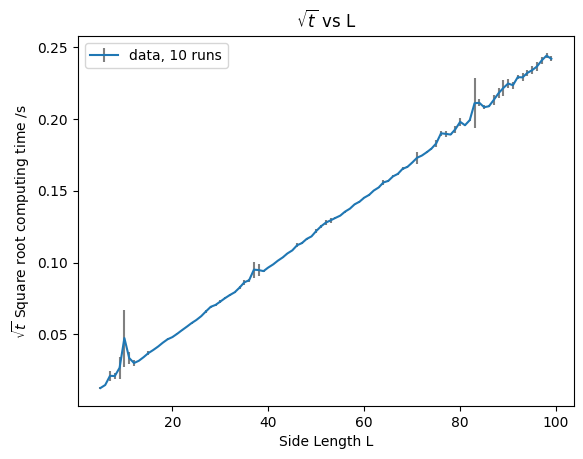

In [19]:
plt.errorbar(Ls, [np.sqrt(t) for t in times_avg], yerr = [np.sqrt(t+s) - np.sqrt(t) for t,s in zip(times_avg, times_std)], ecolor='grey', label='data, 10 runs')
plt.title('$\sqrt{t}$ vs L')
plt.xlabel('Side Length L')
plt.ylabel('$\sqrt{t}$ Square root computing time /s')
plt.legend()
plt.show()

As expected, the total initialization and percolation time clearly scales as $t \propto L^2$. The graph above also shows a very small error, and so runtimes are extremely simmilar between different (randomly initialized) runs. We have therefore verified that our Newman-Ziff implementation displays $O(L^2) = O(M)$ complexity. However, this may be slowed down by the measurement of $Q_n$; this is discussed in Section 3.

### Mertens Algorithm Implementation
We now move on to implement the final algorithm, which is the Mertens Algorithm introduced in [5]. This algorithm uses a transfer matrix method, as described in Section 1. 

The crux of the algorithm is the _extend_ subroutine, which converts a signature $\sigma$ to its 2 possible children $\sigma_1, \sigma_0$. The rules for this are contained in Table 3 of [5].

Our code below stores signatures as a string, where each element in the string can take one of 6 values:
| Syntax Below | Syntax in paper | Description |
| --- | --- | ----------- |
| L | (( | leftmost member of cluster
| R | )) | rightmost member of cluster
| C | () | isolated cluster
| M | )( | middle of cluster
|T | II | connected to top (any)

The signature string contains the top $N-c$ elements (left to right), and then the $c$ elements on the row underneath (left to right).

The _extend_ subroutine is implemented in the function _extend_. This makes use of the methods _rule\_b_, _rule\_c_, _rule\_d_ as described in Table 3 of [5]. Rule (a) of Table 3 is naturally included in the _extend_ subroutine. The method _calculate\_F_ then calculates $F(z)$ as described in Section 1, following the pseudocode contained in Figure 5 of [5].

The Mertens algorithm is dynamic in nature; we therefore leave behind object-oriented programming here (OOP), in favour of a dynamic programming approach making use of only functions.

<ins>Note:</ins> Table 3 of [5] actually contans some errors (bottom right element can never occur), as does the pseudocode in Figure 5 ($\sigma_0$ should be $\sigma_1$ on line 11). Spotting and correcting these errors made the implementation of this algorithm quite tricky.

We first implement the _extend_ subroutine, along with its associated rules:


In [20]:
def extend(sigma: str, c: int) -> tuple: 
    """
    Generates 2 signtures sigma_1, sigma_0, by extending an input signature sigma with an open/closed site respectively. 

    In Table 4 of [5], the example given is extend('L_C_M_RC_TT', c=4).
    To help spot problems, this function raises errors if the signatures are unbalanced or impossible.


    Parameters
    ----------
    sigma : str
        The signature which we wish to extend.
    c : int
        The column index of the 'kink' in the signature.
    
    Returns
    -------
    sigma_1, sigma_0 : tuple of str
        Possible signatures resulting from the addition of an open/closed site.
    """
    if c==0:  #starting a new row
        updates_open = {'L': 'L', 'T':'T', '_':'C', 'C':'C'}
        sigma_1 = sigma[1:]+updates_open[sigma[0]]
        if sigma[0]=='T' and sigma[-1] in ('_', 'R', 'C') and sigma.count('T') == 1: #rule (a)
            sigma_0 = None
        else:
            sigma_0 = rule_b(sigma, c)[1:]+'_'
        
    else:  #part-way through a row
        left_upper = sigma[-1] + sigma[0]

        updates_open = {                                                            #copied from table 3
                '__':'_C', '_T':'_T', '_L':'_L', '_R':'_R', '_M':'_M', '_C':'_C',
                'T_':'TT', 'TT':'TT', 'TL':'TT', 'TC':'TT',
                'L_':'LM', 'LL':'LM', 'LR':'LR', 'LM':'LM', 'LC':'LM',
                'R_':'MR', 'RT':'TT','RL':'MM', 'RR':'MR', 'RM':'MM', 'RC':'MR',
                'M_':'MM', 'ML':'MM', 'MR':'MR', 'MM':'MM', 'MC':'MM',
                'C_':'LR', 'CT':'TT','CL':'LM', 'CR':'MR', 'CM':'MM', 'CC':'LR'
        }
        updates_closed = {                                                            #copied from table 3
                '__':'__', '_T':'__', '_L':'__', '_R':'__', '_M':'__', '_C':'__',
                'T_':'T_', 'TT':'T_', 'TL':'T_', 'TC':'T_',
                'L_':'L_', 'LL':'L_', 'LR':'C_', 'LM':'L_', 'LC':'L_',
                'R_':'R_', 'RT':'R_','RL':'R_', 'RR':'R_', 'RM':'R_', 'RC':'R_',
                'M_':'M_', 'ML':'M_', 'MR':'R_', 'MM':'M_', 'MC':'M_',
                'C_':'C_', 'CT':'C_','CL':'C_', 'CR':'C_', 'CM':'C_', 'CC':'C_'
        }

        if left_upper not in updates_open:
            raise Exception('An impossible signature has been generated: c='+str(c)+', sigma='+sigma)
        if sigma.count('L') != sigma.count('R'):
            raise Exception('Unbalanced signature: c='+str(c)+', sigma='+sigma)
        
        sigma_1 = rule_d(rule_c(sigma, c),c)[1:-1]+updates_open[left_upper]
        if sigma_1.count('L') != sigma_1.count('R'):
            raise Exception('Unbalanced child signature sigma_1: c='+str(c)+', sigma_1='+sigma_1)
        
        if sigma[0]=='T' and sigma[-1] in ('_', 'R', 'C') and sigma.count('T') == 1: #rule (a)
            sigma_0 = None
        else:
            sigma_0 = rule_b(sigma, c)[1:-1]+updates_closed[left_upper]
            if sigma_0.count('L') != sigma_0.count('R'):
                raise Exception('Unbalanced child signature sigma_0: c='+str(c)+', sigma_0='+sigma_0)

        

    return sigma_0, sigma_1  


def rule_b(sigma: str, c: int) -> str:
    """
    Implements Rule b: deleting L or R means shortening of the corresponding cluster.


    Parameters
    ----------
    sigma : str
        The signature which we wish to fix.
    c : int
        The column index of the 'kink' in the signature.
    
    Returns
    -------
    sigma : str
        Fixed (balanced) signature
    """
    sigma = list(sigma)

    if c != 0:
        if sigma[0] == 'L':
            cluster_num = 0
            for i in range(1,len(sigma)-c):
                char = sigma[i]
                if char == 'M' and cluster_num == 0:
                    sigma[i] = 'L'
                    break
                elif char == 'R' and cluster_num == 0:
                    sigma[i] = 'C'
                    break
                elif char == 'L':
                    cluster_num+=1
                elif char == 'R':
                    cluster_num -=1
        elif sigma[0] == 'R' and sigma[-1] in ('_', 'R', 'C'):
            cluster_num = 0
            for i in range(1,c+1):
                char = sigma[-i]
                if char == 'M' and cluster_num == 0:
                    sigma[-i] = 'R'
                    break
                elif char == 'L' and cluster_num == 0:
                    sigma[-i] = 'C'
                    break
                elif char == 'R':
                    cluster_num+=1
                elif char == 'L':
                    cluster_num -=1
        elif sigma[0] == 'C' and sigma[-1] == 'C':
            pass

    if c == 0:
        if sigma[0] == 'L':
            cluster_num = 0
            for i in range(1,len(sigma)):
                char = sigma[i]
                if char == 'M' and cluster_num == 0:
                    sigma[i] = 'L'
                    break
                elif char == 'R' and cluster_num == 0:
                    sigma[i] = 'C'
                    break
                elif char == 'L':
                    cluster_num+=1
                elif char == 'R':
                    cluster_num -=1


    return ''.join(sigma)

def rule_c(sigma: str, c: int) -> str:
    """
    Implements Rule c: connect an entire (merged) cluster to top.


    Parameters
    ----------
    sigma : str
        The signature which we wish to fix.
    c : int
        The column index of the 'kink' in the signature.
    
    Returns
    -------
    sigma : str
        Fixed signature, with appropriate cluster connected to top.
    """
    sigma = list(sigma)

    if sigma[0] == 'T' and sigma[-1]=='R':
        cluster_num = 0
        for i in range(1,c+1):
            char = sigma[-i]
            if char == 'R':
                cluster_num+=1
            if char in ('M', 'R') and cluster_num == 1:
                sigma[-i] = 'T'
            if char == 'L' and cluster_num == 1:
                sigma[-i] = 'T'
                break
            if char == 'L':
                cluster_num -=1
    if sigma[0] == 'L' and sigma[-1]=='T':
        cluster_num = 0
        for i in range(len(sigma)-c):
            char = sigma[i]
            if char == 'L':
                cluster_num+=1
            if char in ('M', 'L') and cluster_num == 1:
                sigma[i] = 'T'
            if char=='R' and cluster_num == 1:
                sigma[i] = 'T'
                break
            if char == 'R':
                cluster_num -=1
    
    return ''.join(sigma)

def rule_d(sigma: str, c: int) -> str:
    """
    Implements Rule d: connect 2 clusters.


    Parameters
    ----------
    sigma : str
        The signature which we wish to fix.
    c : int
        The column index of the 'kink' in the signature.
    
    Returns
    -------
    sigma : str
        Fixed signature, with appropriate clusters connected.
    """
    sigma = list(sigma)
    if sigma[0] == 'L' and sigma[-1] in ('L', 'M'):
        cluster_num = 0
        for i in range(1, len(sigma)-c):
            char = sigma[i]
            #print(cluster_num, char)
            if char == 'L':
                cluster_num+=1
            if char =='R' and cluster_num == 0:
                sigma[i] = 'M'
                break
            elif char == 'R':
                cluster_num -=1
    elif sigma[-1] == 'R' and sigma[0] in ('M', 'R'):
        cluster_num = 0
        for i in range(1,c+1):
            char = sigma[-i]
            #print(cluster_num, char)
            if char == 'R':
                cluster_num+=1
            if char == 'R' and cluster_num == 1:
                sigma[-i] = 'M'
            if char == 'L' and cluster_num == 1:
                sigma[-i] = 'M'
                break
            elif char == 'L':
                cluster_num -=1
    return ''.join(sigma)


We also include a function to generate all possible top rows, _L\_old\_generate_:

In [21]:
def L_old_generate(z : float , N : int):
    """
    Generates all possible top row signatures (2^N), along with their associated function F.


    Parameters
    ----------
    z : float
        Input parameter to F(z)
    N : int
        Grid width
    
    Returns
    -------
    [(sigma, F)] : list of tuples
        A list of pairs (sigma, F^sigma(z)).
    """
    L_old = ['_', 'T']
    L_new = []

    for i in range(N-1):
        for sigma in L_old:
            L_new.append(sigma+'_')
            L_new.append(sigma+'T')
        L_old, L_new = L_new, []
    
    sigmas=L_old[1:]  #we don't need to include the entirely blank top row
    F_s = [z**(i.count('T')) for i in sigmas]

    return [(sigma, F) for sigma, F in zip(sigmas, F_s)]


Finally, we reproduce the (corrected) pseudocode contained in Figure [5] of 5 in order to calculate $F(z)$:

In [22]:
def calculate_F(z: float, N: int) -> float:
    """
    Calculate F(z) on an NxN grid


    Parameters
    ----------
    z : float
        Input parameter to F(z)
    N : int
        Grid width N
    
    Returns
    -------
    F_total : float
        The calculated F(z)
    """

    L_old = L_old_generate(z, N)
    L_new = []

    for r in np.arange(1, N): #first row already generated!
        for c in np.arange(N):
            while L_old != []:
                (sigma, F_sigma) = L_old.pop()
                sigma_0, sigma_1 = extend(sigma, c)
                
                if sigma_0 != None:
                    present = False
                    for i in np.arange(len(L_new)):
                        s,F = L_new[i]
                        if s == sigma_0:
                            L_new[i]  = (sigma_0, F + F_sigma)
                            present = True
                    if present == False:
                        L_new.append( (sigma_0, F_sigma) )

                present = False
                for i in np.arange(len(L_new)):
                    s, F = L_new[i]
                    if s == sigma_1:
                        L_new[i]  = (sigma_1, F + z*F_sigma)
                        present = True
                if present == False:
                    L_new.append( (sigma_1, z*F_sigma) )
            L_old, L_new = L_new, L_old
    F_total = np.sum([i[1] for i in L_old])

    return F_total


Let's verify that our code is functioning correctly by calculating $F(z)$ for $N=2, z=\frac{1}{2}$. Recall $F(z) := \sum_k A_k z^k$ for $A_k$ percolating configurations with $k$ open sites. As shown below, we should expect a value of $1.0625$.

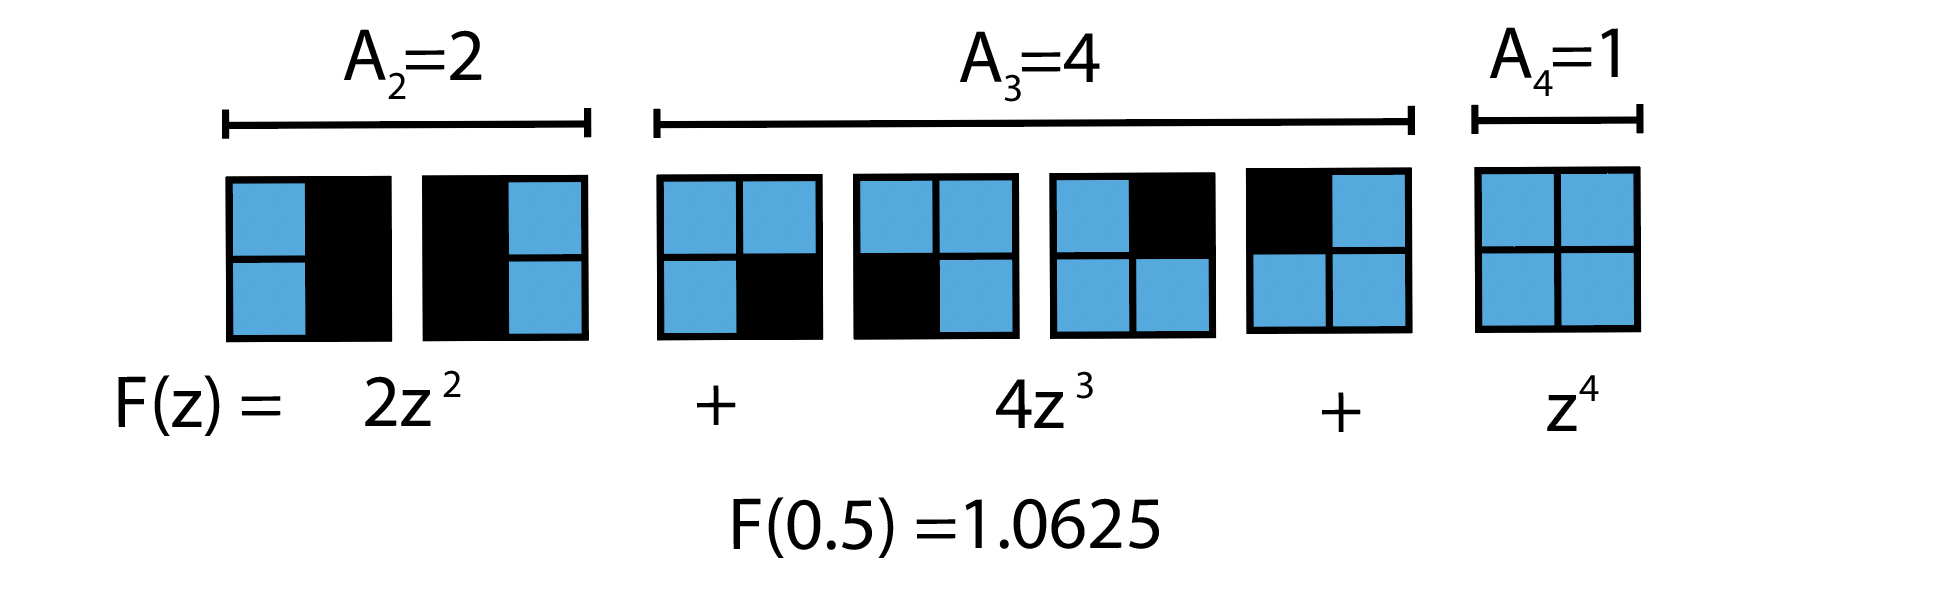

In [23]:
print(calculate_F(0.5, 2))

1.0625


Wonderful! Our code reproduces the correct analytical result for the case $F_{2,2}(0.5)$. Let's now check that we can generate some sensible looking spanning probabilities for a larger grid, using the formula $R_{N,N}(p) = (1-p)^{N^2} F_{N, N} \big( \frac{p}{1-p} \big)$:

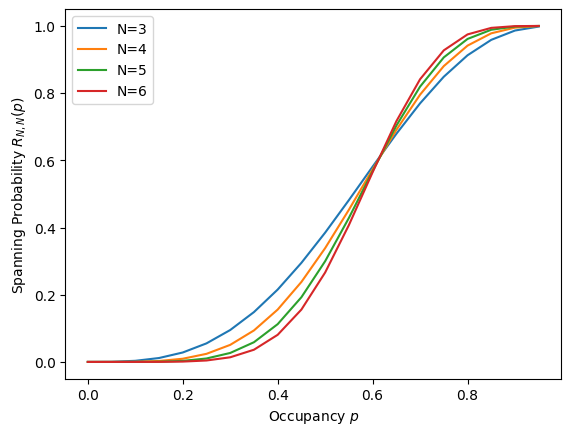

In [24]:
P = np.arange(0, 1, 0.05)

for N in range(3,7):
    P_span = [((1-p)**(N*N)) * calculate_F((p/(1-p)), N) for p in P]
    plt.plot(P, P_span, label='N='+str(N))
plt.xlabel('Occupancy $p$')
plt.ylabel('Spanning Probability $R_{N,N}(p)$')
plt.legend()
plt.show()

This has the features we expect:
- A sigmoid curve, starting at $R=0$ for occupancy $p=0$, tending to $R=1$ at $p=1$.
- The curve us increasingly sharp with increasing $N$, as we expect a step-like phase transition as $N \rightarrow \infty$.
- $R_{N,N}(p) = R_{N-1,N-1}(p)$ for $p=p_\text{med}$, which converges to $p_c$.

Finally, we wish to verify the time-complexity of the function. As discussed in Section 1, we expect the time to calculate $F_{N,N}(z)$ to go as $O(\lambda^N)$.

In [25]:
times_avg = []
times_std = []

Ns = np.arange(2,8, dtype=int)

for N in Ns:
    times = []
    for i in range(10):
        t_0 = time.perf_counter()
        calculate_F(0.5, N)
        t_1 = time.perf_counter()
        times.append(t_1-t_0)
    times_avg.append(np.mean(times))
    times_std.append(np.std(times))

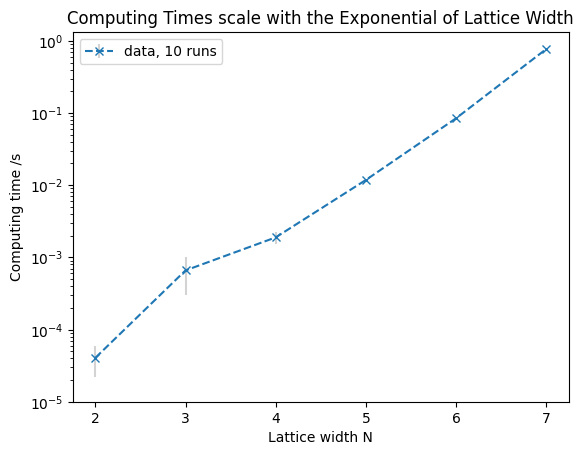

In [26]:
fig, ax = plt.subplots(1,1)

ax.set_yscale("log", nonpositive='clip')
ax.errorbar(Ns, times_avg, yerr= [sigma for sigma in times_std], ecolor='lightgrey', label='data, 10 runs', fmt='--x')
#ax.plot(Ns, [10**(0.8*N-5.7) for N in Ns])
ax.set_ylim(bottom=10**(-5))

ax.set(title='Computing Times scale with the Exponential of Lattice Width')
ax.set(ylabel='Computing time /s')
ax.set(xlabel='Lattice width N')
ax.legend(loc='upper left')


plt.show()

A straight line here shows that we have exponential scaling behaviour, as expected. Note that a naïve implementation of exact probability measurement, without making the efficiency gains of the Mertens algorithm, would scale at least as $O(2^{N^2})$, as discussed in Section 1, and so would appear as a parabola on the above plot.



We can now conclude Section 2. We have implemented 3 algorithms (Leath-Alexandrowicz, Newman-Ziff, Mertens). We have verified the proper behaviour of each algorithm by performing some representative tests. We have tested the time-complexity of each algorithm, and compared this to the theoretical complexity, which has been successfully achieved in all 3 cases. We now move onto Section 3, where we will investigate the computational physics of Percolation using these algorithms.

## Section 3: Tests \& Results


We have now implemented the 3 algorithms described in Section 1, and verified their theoretical complexity in Section 2. We proceed to use these algorithms to investigate the computational physics of percolation. In particular, we seek an accurate estimate of $p_c$. The focus on this section is therefore physical quantities, instead of computing time, although this will be mentioned. The same hardware is used for these tests as was used for Section 2.

All runs which are not executed quickly (<2 minutes) have been saved, and saved data is used to reproduce the figures. In these cases, the relevant code block is only executed if some _RUN_ variable is set True. Shorter runs are performed automatically on execution of the code block.

### Cluster Sizes \& Scaling Exponents
First, we wish to investigate typical cluster sizes. As a reminder, the _average cluster size_ $S(p)$ defined with respect to a site (i.e. the average size of the cluster containing a given open site) diverges as
$$ S(p) \sim |p-p_c|^{-\gamma} $$
in the $N \rightarrow \infty$ limit. We will now investigate the quantities $p_c, \gamma$ using the first 2 methods introduced above: Single Cluster Growth, and Newman-Ziff.


**Single Cluster Growth**\
Let's use the Single-Cluster Growth algorithm to grow $35,000$ clusters over a spectrum of $p$. We only investigate up to $p=0.7$, as this is well above the rough percolation threshold we were previously able to establish, and so clusters here will be entirely limited by the max_size cutoff.

In [27]:
p_spectrum = np.arange(0.0, 0.7, 0.02)
GROW_AND_SAVE = False 

if GROW_AND_SAVE:
    sizes = []
    for p in p_spectrum:
        sizes.append([]) 
        for i in range(1000):
            size_test_grid = SingleClusterGrid(10**3)
            _, size, _ = size_test_grid.grow_from_seed_FIFO(p, max_size=10**4)
            sizes[-1].append(size)

    np.save('single_cluster_data', np.array(sizes))


This took about 2 minutes and 50 seconds to run, to generate 35,000 clusters. The data is saved to the file _single\_cluster\_data\.npy_ , and so there is no need to run the above code again to generate the plots below. We should now check how these clusters look:

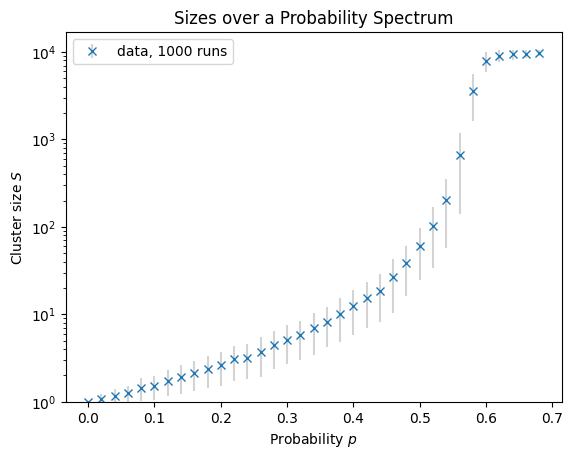

In [28]:
with open('single_cluster_data.npy', 'rb') as f:
    sizes = np.load(f)


sizes_mean = np.mean(sizes, axis=1)
sizes_std = np.std(sizes, axis=1)

fig, ax = plt.subplots(1,1)

ax.set_yscale("log", nonpositive='clip')
ax.errorbar(p_spectrum, sizes_mean, yerr= [0.5*sigma for sigma in sizes_std], ecolor='lightgrey', label='data, 1000 runs', fmt='x')
ax.set_ylim(bottom=1)

ax.set(title='Sizes over a Probability Spectrum')
ax.set(ylabel='Cluster size $S$')
ax.set(xlabel='Probability $p$')
ax.legend(loc='upper left')


plt.show()

As expected, clusters diverge up to $p_c$, and are then limited by the max cluster size, which we have set here to $10^4$ to save computing time. We can also check the distribution of cluster sizes _within_ a given $p$:

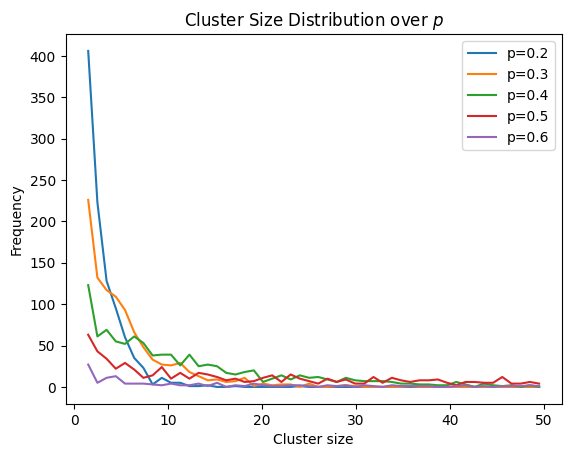

In [29]:
ps_section = p_spectrum[0::5]
sizes_section = sizes[0::5]

for i in range(2, len(ps_section)):
    hist, bin_edges = np.histogram(sizes_section[i], bins=50, range=(1, 50))
    bin_center = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
    plt.plot(bin_center, hist, label='p='+str(ps_section[i]))
plt.title('Cluster Size Distribution over $p$')
plt.xlabel('Cluster size')
plt.ylabel('Frequency')
plt.legend()
plt.show()

As expected, at larger values of $p$, we see higher typical cluster sizes, with a distribution simmilar to that found in Figure 4 of [1].

We now use this _sizes_ data to try to fit $p_c, \gamma$, using the expected cluster size:
$$ S(p) = \text{min}(|p_c-p|^{-\gamma}, S_\text{max}) $$
also imposing an intercept of $1$ at $p=0$.

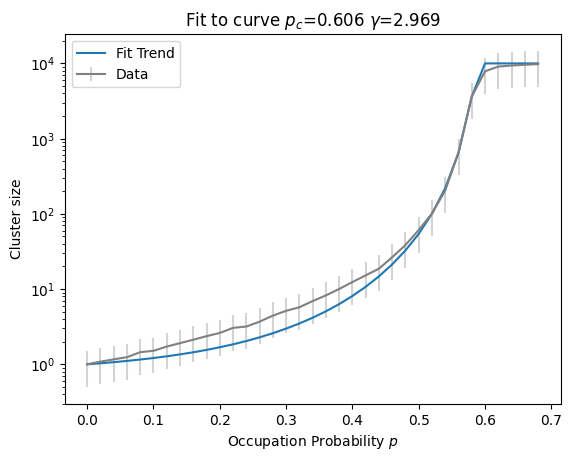

In [30]:
with open('single_cluster_data.npy', 'rb') as f:
    sizes = np.load(f)
sizes_mean = np.mean(sizes, axis=1)
sizes_std = np.mean(sizes, axis=1)
p_spectrum = np.arange(0.0, 0.7, 0.02)


def f(ps, p_c, gamma, A):
    """Expected cluster size, incooperating Max cluster size and constraint S(p=0)=1"""
    output = []
    for p in ps:
        if p<p_c:
            output.append(min(A*(abs(p-p_c))**(-gamma)+1-A*p_c**(-gamma), 10**4))
        else:
            output.append(10**4)
    return output

all_ps = [p for p in p_spectrum for _ in range(len(sizes[1]))]
all_sizes = np.ndarray.flatten(sizes)

popt, pcov = scipy.optimize.curve_fit(f, all_ps, all_sizes, p0 = [0.59, 2, 0.4])
p_c, gamma, A = popt


plt.semilogy()
plt.errorbar(p_spectrum, sizes_mean, yerr=0.5*sizes_std, color='grey', ecolor='lightgrey', label='Data')
plt.semilogy(p_spectrum, f(p_spectrum, p_c, gamma, A), label='Fit Trend')
plt.xlabel('Occupation Probability $p$')
plt.ylabel('Cluster size')
plt.title('Fit to curve $p_c$='+str(round(p_c, 3))+' $\gamma$='+str(round(gamma, 3)))
plt.legend()
plt.show()


The Single-Cluter data therefore gives estimates of $p_c = 0.606, \gamma=2.97$. While these are roughly simmilar to the accurate values given in [7] of $0.5927, 2.39$, the agreement is only to the first significant figure. We can fairly easily identify the problem; the constraint of $S=10^4$ on our cluster size means that infinite clusters cannot grow, and so the average cluster size is too small in the region of $p_c$. This _increases_ the observed values of $p_c$ and $\gamma$. While we could generate a more accurate estimate using a higher max size, this will not remove the problem, and will significantly increase the computing time. We therefore turn to the Newman-Ziff method to provide a better estimate.

**Newman-Ziff Method**\
We can measure the average cluster size $S$ in the Newman-Ziff method using the formula [8]:
$$ S = \frac{\sum_{s=0}^\infty s^2 n_s }{\sum_{s=0}^\infty s n_s } := \frac{M_2}{M_1}$$
where $n_s$ is the number of clusters of size $s$ in the grid. We implement this in a new class, _ZiffGrid\_ClusterSizesMeasurement_, which inherits from _ZiffGrid_. We measure $\{Q_n\}$ (in this case $S_n$) over 5 runs to get $\{\overline{Q_n}\}$. We also define, and then use, the Binomial convolution discussed in Section 1 to get $Q(p)$


In [31]:
class ZiffGrid_ClusterSizesMeasurement(ZiffGrid):
    """ZiffGrid, but with the modification that Q measures the typical cluster size S."""
    def measure_Q(self) -> list:

        sizes=[-n for n in self.pointers if n!=-self.N-1 and n<0]

        M_1 = np.sum([s*sizes.count(s) for s in np.arange(self.N, dtype=int)])
        M_2 = np.sum([(s**2)*sizes.count(s) for s in np.arange(self.N, dtype=int)])
        
        return M_2/M_1

def Q(p, Qn):
    N = len(Qn)
    return np.sum([scipy.special.comb(N, n) * p**n * (1-p)**(N-n)*Qn[n] for n in range(N-1)])

Qn_all = []
for i in range(10):
    L=30
    ziff_cluster_sizes = ZiffGrid_ClusterSizesMeasurement(L)
    ns, Ss = ziff_cluster_sizes.percolate()
    Qn_all.append(Ss)
Qn_mean = np.mean(Qn_all, axis=0)

/var/folders/3q/bs71m3ns1kq5sjlny3rn8t5r0000gn/T/ipykernel_51122/2922907719.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return M_2/M_1


Examining this data:

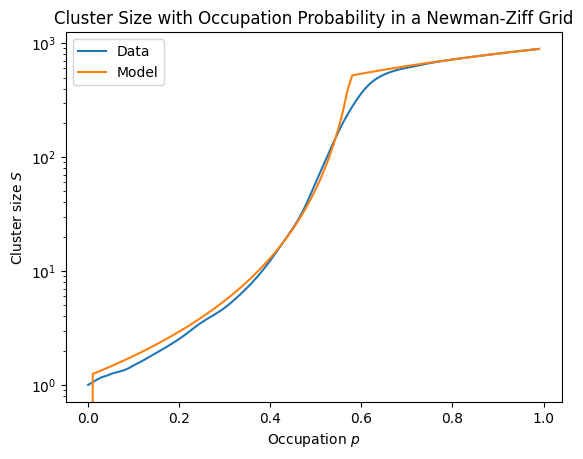

In [32]:
ps = np.arange(0, 1, 0.01)
Qs = [Q(p, Qn_mean) for p in ps]

plt.semilogy(ps, Qs, label='Data')
plt.xlabel('Occupation $p$')
plt.ylabel('Cluster size $S$')
plt.title('Cluster Size with Occupation Probability in a Newman-Ziff Grid')

def f(ps, p_c, gamma, A):
    output = []
    N=900
    for p in ps:
        if p<p_c:
            output.append(min(A*(abs(p-p_c))**(-gamma), p*N))
        else:
            output.append(p*N)
    return output

plt.semilogy(ps, f(ps, 0.62, 2.3, 0.4), label='Model')
plt.legend()


plt.show()

As before, the limited size of the Grid prevents an accurate fit to the model around $p \sim p_c$. Furthermore, measurement of $S$ using the method described above takes time $O(M)$ for each $Q_n$, bringing the total complexity of a single sweep up to $O(M^2)$. We therefore move onto an investigation of wrapping/spanning probabilities, which we will use to more accurately and precisely determine $p_c$ (and scaling coefficients), even at finite grid size.

### Wrapping Measurements: Newman-Ziff
We now move onto measuring the critical probability threshold using wrapping measurements, taken using the Newman-Ziff method. We choose to use wrapping measurements, instead of spanning measurements, as these can be shown to converge faster to the true values at fininte $L$ [3].

First, we need to slightly adapt our _ZiffGrid_ class to detect the onset of wrapping. To do this, we add a vector to the _pointers_ attribute. The vector points to the root node of a site. We can then detect wrapping when 2 sites with the same root node come into contact which have _different_ vectors, i.e. one of the vectors wraps around the cluster. This is explained in more detail in Figure 7 of [3]. 

In [33]:
class ZiffGrid_ReturnWrapping(ZiffGrid):
    def __init__(self, L: int) -> None:
        """
        Initialize the lattice as in the parent ZiffGrid class, but with the pointers now containing vector displacements from their roots.

        Parameters
        ----------
        L : int
            Grid side length
        """
        super(ZiffGrid_ReturnWrapping, self).__init__(L)
        self.pointers=np.zeros((self.N, 3), dtype='i')
    
    def findroot(self, i: int) -> list: 
        """
        Find the pointer (position and vector) to the root of a point i. Perform path compression.

        Parameters
        ----------
        i : int
            Position of input site

        Returns
        ----------
        pointers[i] : list of 3 integers
            Pointer to root site.
        """
        if (self.pointers[i, 0]<0): #if root node
            return i,0,0
        
        else:
            point=i
            path=[i]
            while self.pointers[self.pointers[point,0],0]>0: #create a path to the root site
                point = self.pointers[point,0]
                path.append(point)
            root = (self.pointers[point,0])%self.N


            for points in path: #compression of pointers[0]
                self.pointers[points,0] = root
            
            while len(path)!=1: #compression of pointer vectors
                last_point = path.pop(-1)
                self.pointers[path[-1],1] = self.pointers[path[-1],1] + self.pointers[last_point,1]
                self.pointers[path[-1],2] = self.pointers[path[-1],2] + self.pointers[last_point,2]
            
            return self.pointers[i]

    def percolate_wrapping(self):
        """
        Detect the onset of wrapping.

        Returns
        ----------
        ns: list
            List of numbers of open sites
        percolation_times: tuple of 2 integers
            Number of sites required for vertical, horizontal wrapping
        """
        empty=-(self.N+1) #unassigned grid value

        ns=np.zeros(self.N)
        percolation_times = [0,0]

        for i in np.arange(self.N): #initialize the grid to empty
            self.pointers[i,0]=empty

        for i in np.arange(self.N):
            site_root=site_pos_copy=np.copy(self.order[i]) #site position to occupy
            self.pointers[site_pos_copy,0]=-1 #set site as the root of its own cluster
            
            
            neighbours_coords=[(1,0),(-1,0),(0,1),(0,-1)]
            for neighbour_pos, neighbour_displacement in zip(self.neighbours[site_pos_copy], neighbours_coords): #checking the neighbours
                if self.pointers[neighbour_pos,0] != empty: #if in grid
                    neighbour_root=self.findroot(neighbour_pos)[0]

                    if (neighbour_root!=site_root):
                        
                        if self.pointers[site_root,0]>self.pointers[neighbour_root,0]: #site is in a smaller cluster
                            #perform union, adjusting the pointers
                            self.pointers[neighbour_root,0]=self.pointers[neighbour_root,0]+self.pointers[site_root,0] #adjust cluster size

                            self.pointers[site_root,0]=neighbour_root%self.N
                            self.pointers[site_root,1]=-self.pointers[site_pos_copy,1]+self.pointers[neighbour_pos,1] + neighbour_displacement[0]
                            self.pointers[site_root,2]=-self.pointers[site_pos_copy,2]+self.pointers[neighbour_pos,2] + neighbour_displacement[1]
                        
                            self.pointers[site_pos_copy,0]=neighbour_root
                            self.pointers[site_pos_copy,1]=self.pointers[neighbour_pos,1] + neighbour_displacement[0]
                            self.pointers[site_pos_copy,2]=self.pointers[neighbour_pos,2] + neighbour_displacement[1]
                        
                            site_root=np.copy(neighbour_root)

                        else: #site is in larger cluster
                            #perform union, adjusting the pointers
                            self.pointers[site_root,0]=self.pointers[site_root,0]+self.pointers[neighbour_root,0]

                            self.pointers[neighbour_root,0]=site_root%self.N
                            self.pointers[neighbour_root,1]= +self.pointers[site_pos_copy,1]-self.pointers[neighbour_pos,1] - neighbour_displacement[0]
                            self.pointers[neighbour_root,2]= +self.pointers[site_pos_copy,2]-self.pointers[neighbour_pos,2] - neighbour_displacement[1]
                            
                            self.pointers[neighbour_pos,0]=site_root
                            self.pointers[neighbour_pos,1]=self.pointers[site_pos_copy,1] - neighbour_displacement[0]
                            self.pointers[neighbour_pos,2]=self.pointers[site_pos_copy,2] - neighbour_displacement[1]

                    else: #belong to same cluster
                        a,a_1,a_2 = self.findroot(site_pos_copy)
                        b,b_1,b_2 = self.findroot(neighbour_pos)
                        
                        if a==b:
                            relative_difference = [(a_1-b_1-neighbour_displacement[0]),(a_2-b_2-neighbour_displacement[1])]

                            if relative_difference != [0,0]: #wrapping
                                if [abs(relative_difference[0]), abs(relative_difference[1])]==[self.L,0] and percolation_times[0]==0:
                                    percolation_times[0] = i
                                elif [abs(relative_difference[0]), abs(relative_difference[1])]==[0,self.L] and percolation_times[0]==0:
                                    percolation_times[1] = i
                                elif [abs(relative_difference[0]), abs(relative_difference[1])]==[self.L,self.L]:
                                    if  percolation_times[0]==0:
                                        percolation_times[0] = i
                                    if  percolation_times[1]==0:
                                        percolation_times[1] = i
                        
                
            ns[i]= (i+1)
            
        return ns, percolation_times


Next, we take some data of the probabilities at which we have single wrapping, and double wrapping, over lattice sizes $32,64,128,256$. Note that the error scales (for a given number of runs) as $L^{-3/2}$, as shown in Section III.A of [3]. We use $2000$ runs, before taking averages to generate the set $\{ \overline{Q_n} \}$.

This takes 94 minutes to run, if we set _RUN\_AND\_SAVE_ to true (default set to false). Sample data is already saved, so plots below are reproduced without needing to run this block.

In [34]:
side_lengths = [32,64,128,256]
RUN_AND_SAVE = False

if RUN_AND_SAVE:
    Qs_vertical_avgs = []
    Qs_horizontal_avgs = []
    Qs_one_avgs = []
    Qs_both_avgs = []

    for side_length in side_lengths:
        Qs_vertical=[]
        Qs_horizontal=[]
        Qs_one=[]
        Qs_both=[]
        for i in range(2000):
            test = ZiffGrid_ReturnWrapping(side_length)
            ns,percolation_times = test.percolate_wrapping()
            Qs_vertical.append([np.heaviside(n-percolation_times[1],1) for n in ns])
            Qs_horizontal.append([np.heaviside(n-percolation_times[0],1) for n in ns])
            Qs_one.append([np.heaviside(n-min(percolation_times[1], percolation_times[0]),1) for n in ns])
            Qs_both.append([np.heaviside(n-min(percolation_times[1], percolation_times[0]),1) - np.heaviside(n-max(percolation_times[1], percolation_times[0]),1) for n in ns])

        Qs_vertical_avg=np.mean(Qs_vertical, axis=0)
        Qs_horizontal_avg=np.mean(Qs_horizontal, axis=0)
        Qs_one_avg=np.mean(Qs_one, axis=0)
        Qs_both_avg=np.mean(Qs_both, axis=0)

        Qs_vertical_avgs.append(Qs_vertical_avg)
        Qs_horizontal_avgs.append(Qs_horizontal_avg)
        Qs_one_avgs.append(Qs_one_avg)
        Qs_both_avgs.append(Qs_both_avg)

    for side_length_index in range(len(side_lengths)):
        Qs_side_length = [] 
        Qs_side_length.append(Qs_vertical_avgs[side_length_index])
        Qs_side_length.append(Qs_horizontal_avgs[side_length_index])
        Qs_side_length.append(Qs_one_avgs[side_length_index])
        Qs_side_length.append(Qs_both_avgs[side_length_index])
        np.save('Wrapping_times'+str(side_lengths[side_length_index]), Qs_side_length)

Let's check that this looks sensible. Below, we have plotted the probability function of wrapping one side, but not the other. This should have a maximum at $p=p_c$, and a width which decreases with $L^{\frac{-1}{\nu}}$.

We have also redefined $Q(p)$ to deal with larger lattice sizes, using _scipy.stats.binom.pmf_; this makes the function slower, but is required so that combination numbers don't get out of hand. The convolutions to make the plot below take about 2 minutes. 

/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


[]

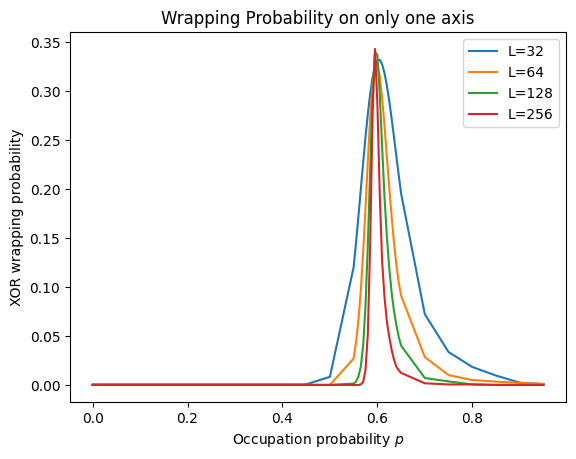

In [35]:
XOR_wrapping_times = []
for side_length in side_lengths:
    wrapping_times = np.load('Wrapping_times'+str(side_length)+'.npy')
    XOR_wrapping_times.append(wrapping_times[3])

def Q(p, Qn):
    N = len(Qn) 
    return np.sum([scipy.stats.binom.pmf(n, N, p)*Qn[n] for n in range(N-1)])

ps = np.concatenate((np.arange(0.0,0.55,0.05), np.arange(0.55, 0.65, 0.01), np.arange(0.65,1.0,0.05)))
for side_length_index in range(len(side_lengths)):
    Q_p = [Q(p, XOR_wrapping_times[side_length_index]) for p in ps]
    plt.plot(ps, Q_p, label='L='+str(side_lengths[side_length_index]))
plt.legend()
plt.xlabel('Occupation probability $p$')
plt.ylabel('XOR wrapping probability')
plt.title('Wrapping Probability on only one axis')
plt.plot()

This looks appropriate; all sizes display a peak at (roughly) the same point, but the width of the curve shrinks for larger lattice sizes, as the phase transition becomes sharper. We may obtain a precise measurement of $p_c$ by looking for the intercept of $R_L(p)$ and $R_{L-1}(p)$. This gives a smaller error than by measuring the maxima of the above graph (see Figure 11 of [3]).

In [52]:
vert_wrapping_times = []
for side_length in side_lengths:
    wrapping_times = np.load('Wrapping_times'+str(side_length)+'.npy')
    vert_wrapping_times.append(wrapping_times[2])

def minus_Q(p, n): #use minus_Q, as we must find a minimum
    Qn = vert_wrapping_times[n]
    N = len(Qn) 
    return -np.sum([scipy.stats.binom.pmf(n, N, p)*Qn[n] for n in range(N-1)])

def difference_Q(p, n):
    return minus_Q(p, n) - minus_Q(p, n-1)

estimates = []
for n in [1,2]:
    sol = scipy.optimize.root_scalar(difference_Q, bracket=(0.55, 0.63), args=(n,))
    estimates.append(sol.root)
    print('Estimate for L='+str(side_lengths[n])+': '+str(sol.root))


/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Estimate for L=64: 0.5930351938624151
Estimate for L=128: 0.5933718912923253


From the Newman-Ziff method, we thus have an estimate of $p_c = 0.593$, which is correct to 3 decimal places. This is an improvement on our Single-Cluster-Growth estimate, but still not very accurate. We can also estimate the critical exponent $\nu$ (convergence of below rootfind algorithm takes 55 seconds):

In [53]:
def halfway_roots(p, n):
    Qn = XOR_wrapping_times[n]
    N = len(Qn) 
    return np.sum([scipy.stats.binom.pmf(n, N, p)*Qn[n] for n in range(N-1)])-0.175

estimates_left = []
for n in [0,1,2,3]:
    sol = scipy.optimize.root_scalar(halfway_roots, bracket=(0.5, 0.5927), args=(n,))
    estimates_left.append(sol.root)

estimates_right = []
for n in [0,1,2,3]:
    sol = scipy.optimize.root_scalar(halfway_roots, bracket=(0.5927, 0.7), args=(n,))
    estimates_right.append(sol.root)

half_width = [right-left for right, left in zip(estimates_right, estimates_left)]


def expected_width(L, A, nu):
    output = []
    for l in L:
        output.append(A*l**(-1/nu))
    return output

popt, pcov = scipy.optimize.curve_fit(expected_width, side_lengths, half_width, p0 = [20, 0.75])


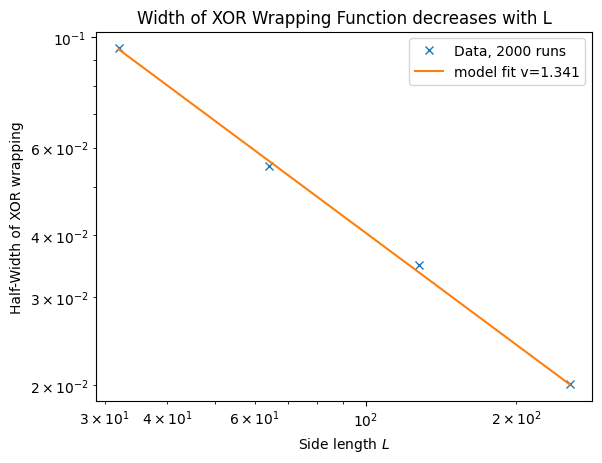

In [51]:
plt.loglog(side_lengths, half_width, 'x',label='Data, 2000 runs')
plt.xlabel('Side length $L$')
plt.ylabel('Half-Width of XOR wrapping')
plt.title('Width of XOR Wrapping Function decreases with L')

plt.plot(side_lengths, expected_width(side_lengths, popt[0], popt[1]), label = 'model fit v='+str(round(popt[1],3)))
plt.legend()
plt.show()

Which gives $\nu \simeq 1.341$, which is correct to 2 decimal places, compared to the real value [3] of $\frac{4}{3}$. We have thus used the Mertens algorithm to obtain Monte-Carlo estimates of $p_c, \nu$, correct to $10^{-3}, 10^{-2}$ respectively.

We now turn to measurements using the Mertens algorithm, for a more precise value of $p_c$.

### Spanning Measurements: Mertens
Our final estimate for $p_c$ will be made using the Mertens algorithm. We use the estimators $p_\text{cell}, p_\text{med}, p_*$, as described in Section 1. As a reminder, these are defined by:
$$ R_{N,N}(p_\text{cell}) = \frac{1}{2} \qquad \qquad R_{N,N}(p_\text{med}) = R_{N-1, N-1}(p_\text{med}) \qquad \qquad p_* := \frac{4}{7} p_\text{med} + \frac{3}{7} p_\text{cell} $$
$$ |p_{\text{med, cell,}*}-p_c| \sim N^{-7/4}  $$
We first calculate these values over a range of $n$. Note that only 1 run is necessary as the Mertens algorithm is exact. Execution of this takes about 12 seconds.

In [2188]:
P = np.arange(0, 1, 0.05)
def R_NN(p, N):
    return (1-p)**(N*N) * calculate_F((p/(1-p)), N)

def R_cell(p,N):
    return R_NN(p,N)-1/2

def R_med(p,N):
    return R_NN(p,N)-R_NN(p,N-1)

ns = [4,5,6,7]

p_cells = []
for n in ns:
    sol = scipy.optimize.root_scalar(R_cell, bracket=(0.55, 0.63), args=(n,))
    p_cells.append(sol.root)

p_meds = []
for n in ns:
    sol = scipy.optimize.root_scalar(R_med, bracket=(0.55, 0.63), args=(n,))
    p_meds.append(sol.root)


Plotting these gives the expected behaviour, as seen in Figure 10 of [5]. $p_*$ is the best estimator for $p_c$.

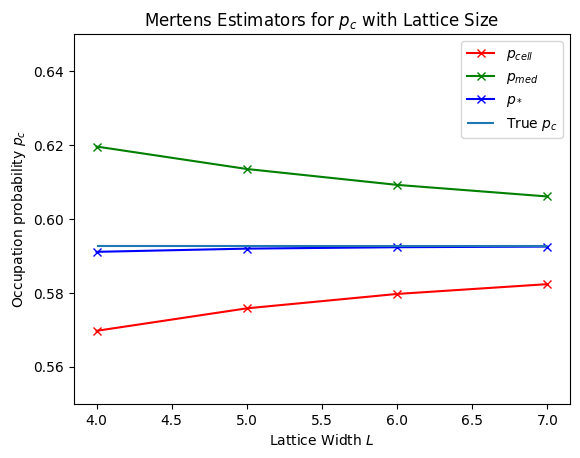

In [2210]:
p_stars = [3/7*p_med + 4/7*p_cell for p_med, p_cell in zip(p_meds, p_cells)]

plt.plot(ns, p_cells,  '-rx', label='$p_{cell}$')
plt.plot(ns, p_meds,  '-gx', label='$p_{med}$')
plt.plot(ns, p_stars,  '-bx', label='$p_*$')

plt.ylim(bottom=0.55, top=0.65)
plt.hlines(0.5927, xmin=min(ns), xmax=max(ns), label='True $p_c$')
plt.title('Mertens Estimators for $p_c$ with Lattice Size')
plt.ylabel('Occupation probability $p_c$')
plt.xlabel('Lattice Width $L$')
plt.legend()
plt.show()

Finally, we may make a precise estimate of $p_c$ by calculating $p_*$ for a larger system side length $n$. Due to the exponential time complexity of the Mertens algorithm, this calculation takes a long time for a larger $n$. The run for $n=9$ took 18 minutes.

In [2302]:
N=9
PERFORM_RUN = False
if PERFORM_RUN:
    sol = scipy.optimize.root_scalar(R_cell, bracket=(0.55, 0.63), args=(N,))
    p_cell = sol.root
    sol = scipy.optimize.root_scalar(R_med, bracket=(0.55, 0.63), args=(N,))
    p_med = sol.root
    p_star = 3/7*p_med + 4/7*p_cell
    
else:
    p_star = 0.592657453 #does not change between runs
print('p* for n='+str(N)+' : '+str(p_star))

p* for n=9 : 0.5926574539230371


We thus have an estimate of $p_c = 0.5923$, which is correct to the 4th decimal place. This result is exact for $n=9$, while the error compared to the $N\rightarrow \infty$ limit can be computed by extrapolating data over multiple values of $n$, as in [10]. This gives the error of $10^{-4}$.

## Conclusion
### Summary
In Section 1, we described 3 algorithms for computing the physical quantities relating to percolation. In Section 2, we implemented these algorithms, and demonstrated their proper functioning. We also observed the clear existance of a percolation threshold. In Section 3, we used these algorithms to provide increasingly precise estimates for $p_c$. Using single-cluster-growth, we obtained $p_c=0.6$, correct to $10^{-1}$. Using Newman-Ziff Monte Carlo methods, we obtained $p_c=0.593$, correct to $10^{-3}$. Finally, we used the exact Mertens algorithm for a grid of side length $L=9$ to obtain an estimate of $p_c=0.5957$, correct to 4 decimal places.

### References
[1]: P. L. Leath, Phys. Rev. B 14, 5046 (1976)\
[2]: Z. Alexandrowicz, Phys. Lett. A 80, 284 (1980)\
[3]: M. Newman, R. Ziff. Phys. Rev. E 64, 016706 (2001)\
[4]: M. E. J. Newman and R. M. Ziff, Phys. Rev. Lett. 85, 4104 (2000)\
[5]: S. Mertens, J. Phys. A: Math. Theor. 55 334002 (2022)\
[6]: S. Smirnov, W. Werner: Math. Res. Lett. 8 729–44 (2001)\
[7]: M. Majewski, K. Malarz: Cond. Matt. Stat. Mech. 10 48550 (2007)\
[8]: https://pypercolate.readthedocs.io/en/stable/percolation-theory.html#:~:text=Average%20cluster%20size&text=p(%CF%B1%2CL)%3D,of%20the%20cluster%20size%20distribution.&text=ws(%CF%B1%2CL)%3D1p(%CF%B1,%CF%B1%2CL)%3D1 \
[9]: https://web.mit.edu/ceder/publications/Percolation.pdf \
[10]:  Jacobsen J L 2015 J. Phys. A: Math. Theor. 48 454003

### Acknowledgements
- All diagrams were created using Adobe Illustrator.